In [1]:
import subprocess
import itertools
import json
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Elimina todo lo que hay en la carpeta /images que tenga la extensión .png (usando rm)

subprocess.run("rm -f images/*", shell=True)         

CompletedProcess(args='rm -f images/*', returncode=0)

In [3]:
import subprocess
import itertools
import json
import re
import os

# Definir los diferentes parámetros
etas = [0.01, 0.1]
mus = [0.5,0.7, 0.9]
layers = [2, 4,6,8,10,12,14,16,18]
neurons = [5,7,9,11,13,15,17,19]
iterations = [2000]
train_files = ["./dat/train_mpg.dat"]
test_files = ["./dat/test_mpg.dat"]

# Resultado JSON
results = {}

# Expresión regular para extraer los errores de entrenamiento y prueba
train_test_regex = r"Train error \(Mean \+- SD\): ([\d\.eE+-]+) \+- ([\d\.eE+-]+)\nTest error \(Mean \+- SD\):\s+([\d\.eE+-]+) \+- ([\d\.eE+-]+)"

# Iterar sobre los índices para asociar correctamente train y test
for idx in range(len(train_files)):
    train_file = train_files[idx]
    test_file = test_files[idx]

    # Iterar sobre todas las combinaciones de eta, mu, layers, neurons e iteraciones
    for eta, mu, l, h, i in itertools.product(etas, mus, layers, neurons, iterations):
        print(f"Ejecutando con eta={eta}, mu={mu}, l={l}, h={h}, i={i}, train={train_file}, test={test_file}")

        # Ejecutar el programa la1.cpp (asegúrate de que el programa se ejecute solo una vez por combinación)
        result = subprocess.run(
            ["./bin/la1", "-t", train_file,"-s", "-T", test_file, "-e", str(eta), "-m", str(mu), "-l", str(l), "-h", str(h), "-i", str(i)],
            capture_output=True, text=True
        )

        # Extraer el error final usando la regex
        final_report = re.search(train_test_regex, result.stdout, re.DOTALL)
        if final_report:
            train_mean, train_std, test_mean, test_std = final_report.groups()

            # Guardar resultados en el JSON con la estructura solicitada
            dataset_name = train_file.split('/')[-1].split('.')[0]
            if dataset_name not in results:
                results[dataset_name] = {}

            eta_mu_key = f"eta={eta} mu={mu}"
            if eta_mu_key not in results[dataset_name]:
                results[dataset_name][eta_mu_key] = {}

            # Iteraciones como primera clave
            if i not in results[dataset_name][eta_mu_key]:
                results[dataset_name][eta_mu_key][i] = {}

            # Capas y luego neuronas
            if l not in results[dataset_name][eta_mu_key][i]:
                results[dataset_name][eta_mu_key][i][l] = {}

            if h not in results[dataset_name][eta_mu_key][i][l]:
                # Solo almacenamos los resultados una vez por combinación de parámetros
                results[dataset_name][eta_mu_key][i][l][h] = {
                    "train_result": {
                        "mean": float(train_mean),
                        "std": float(train_std)
                    },
                    "test_result": {
                        "mean": float(test_mean),
                        "std": float(test_std)
                    }
                }

# Guardar resultados en un archivo JSON usando una ruta absoluta
try:
    with open(os.path.abspath('results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Resultados guardados en {os.path.abspath('results.json')}")
except Exception as e:
    print(f"Error al guardar el archivo JSON: {str(e)}")


Ejecutando con eta=0.01, mu=0.5, l=2, h=5, i=2000, train=./dat/train_mpg.dat, test=./dat/test_mpg.dat
Ejecutando con eta=0.01, mu=0.5, l=2, h=7, i=2000, train=./dat/train_mpg.dat, test=./dat/test_mpg.dat
Ejecutando con eta=0.01, mu=0.5, l=2, h=9, i=2000, train=./dat/train_mpg.dat, test=./dat/test_mpg.dat
Ejecutando con eta=0.01, mu=0.5, l=2, h=11, i=2000, train=./dat/train_mpg.dat, test=./dat/test_mpg.dat
Ejecutando con eta=0.01, mu=0.5, l=2, h=13, i=2000, train=./dat/train_mpg.dat, test=./dat/test_mpg.dat
Ejecutando con eta=0.01, mu=0.5, l=2, h=15, i=2000, train=./dat/train_mpg.dat, test=./dat/test_mpg.dat
Ejecutando con eta=0.01, mu=0.5, l=2, h=17, i=2000, train=./dat/train_mpg.dat, test=./dat/test_mpg.dat
Ejecutando con eta=0.01, mu=0.5, l=2, h=19, i=2000, train=./dat/train_mpg.dat, test=./dat/test_mpg.dat
Ejecutando con eta=0.01, mu=0.5, l=4, h=5, i=2000, train=./dat/train_mpg.dat, test=./dat/test_mpg.dat
Ejecutando con eta=0.01, mu=0.5, l=4, h=7, i=2000, train=./dat/train_mpg.dat,

In [3]:
output_dir = './images/'

# Función para calcular diferencias y mostrar el gráfico de crecimiento del error
def calculate_differences(error_matrix, eta, mu, iteration, neurons, layers, result_type, name):
    horizontal_diff = np.abs(np.diff(error_matrix, axis=1))
    vertical_diff = np.abs(np.diff(error_matrix, axis=0))

    horizontal_labels = [f"{neurons[i]}-{neurons[i+1]}" for i in range(len(neurons)-1)]
    vertical_labels = [f"{layers[i]}-{layers[i+1]}" for i in range(len(layers)-1)]

    # Crear mapas de calor para las diferencias horizontales y verticales
    plt.figure(figsize=(12, 6))

    # Mapa de calor horizontal
    plt.subplot(1, 2, 1)
    sns.heatmap(horizontal_diff, annot=True, fmt=".4f", cmap='coolwarm', xticklabels=horizontal_labels, yticklabels=layers)
    plt.title(f'Horizontal Error Change (eta={eta}, mu={mu}, iter={iteration})')
    plt.xlabel('Neuron Transitions')
    plt.ylabel('Layers')

    # Mapa de calor vertical
    plt.subplot(1, 2, 2)
    sns.heatmap(vertical_diff, annot=True, fmt=".4f", cmap='coolwarm', xticklabels=neurons, yticklabels=vertical_labels)
    plt.title(f'Vertical Error Change (eta={eta}, mu={mu}, iter={iteration})')
    plt.xlabel('Neurons')
    plt.ylabel('Layer Transitions')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'h_e{eta}_m{mu}_{iteration}_{result_type}_{name}.png'))
    plt.close()


# Proceso para generar tablas, gráficos y Pareto para cada combinación de eta y mu
def process_results(results, neurons, layers):
    for dataset_name, result_data in results.items():
        for eta_mu_key, config_data in result_data.items():
            eta_mu_vals = eta_mu_key.split(' ')
            eta = float(eta_mu_vals[0].split('=')[1])
            mu = float(eta_mu_vals[1].split('=')[1])

            for iteration, layer_data in config_data.items():
                # Crear las matrices para train y test
                train_error_matrix = np.zeros((len(layers), len(neurons)))
                test_error_matrix = np.zeros((len(layers), len(neurons)))

                # Recoger los errores en forma de matriz para cada combinación de l y h
                for l_val, neuron_data in layer_data.items():
                    for h_val, errors in neuron_data.items():
                        # Extraer errores de train y test
                        train_error = errors["train_result"]["mean"]
                        test_error = errors["test_result"]["mean"]

                        layer_idx = layers.index(int(l_val))  # Convertir l_val a entero
                        neuron_idx = neurons.index(int(h_val))  # Convertir h_val a entero

                        # Almacenar los errores en las matrices correspondientes
                        train_error_matrix[layer_idx, neuron_idx] = train_error
                        test_error_matrix[layer_idx, neuron_idx] = test_error

                # Calcular las diferencias de error y generar gráficos de crecimiento para train_result
                calculate_differences(train_error_matrix, eta, mu, iteration, neurons, layers, result_type="Train", name=dataset_name)

                # Generar la gráfica del frente de Pareto en 3D para train_result
                plot_pareto_3d(train_error_matrix, eta, mu, iteration, neurons, layers, result_type="Train", name=dataset_name)

                # Calcular las diferencias de error y generar gráficos de crecimiento para test_result
                calculate_differences(test_error_matrix, eta, mu, iteration, neurons, layers, result_type="Test", name=dataset_name)

                # Generar la gráfica del frente de Pareto en 3D para test_result
                plot_pareto_3d(test_error_matrix, eta, mu, iteration, neurons, layers, result_type="Test", name=dataset_name)

                
def find_best_results(results):
    best_train_result = float('inf')
    best_test_result = float('inf')
    best_config_train = None
    best_config_test = None

    # Recorrer cada combinación de dataset, eta, mu, iteraciones, capas, neuronas
    for dataset_name, result_data in results.items():
        for eta_mu_key, config_data in result_data.items():
            eta_mu_vals = eta_mu_key.split(' ')
            eta = float(eta_mu_vals[0].split('=')[1])
            mu = float(eta_mu_vals[1].split('=')[1])

            for iteration, layer_data in config_data.items():
                for l_val, neuron_data in layer_data.items():
                    for h_val, errors in neuron_data.items():
                        # Comparar el train_result (media del error)
                        train_error = errors["train_result"]["mean"]
                        if train_error < best_train_result:
                            best_train_result = train_error
                            best_config_train = {
                                "dataset": dataset_name,
                                "eta": eta,
                                "mu": mu,
                                "iterations": iteration,
                                "layers": l_val,
                                "neurons": h_val,
                                "train_error": train_error
                            }
                        
                        # Comparar el test_result (media del error)
                        test_error = errors["test_result"]["mean"]
                        if test_error < best_test_result:
                            best_test_result = test_error
                            best_config_test = {
                                "dataset": dataset_name,
                                "eta": eta,
                                "mu": mu,
                                "iterations": iteration,
                                "layers": l_val,
                                "neurons": h_val,
                                "test_error": test_error
                            }

    # Retornar los mejores resultados
    return best_config_train, best_config_test


In [4]:
# Función para identificar las soluciones que están en el frente de Pareto
def is_dominated(point, candidates):
    for candidate in candidates:
        if all(candidate <= point) and any(candidate < point):
            return True
    return False

def pareto_frontier(points):
    pareto_points = []
    for point in points:
        if not is_dominated(point, points):
            pareto_points.append(point)
    return np.array(pareto_points)

# Función para dibujar el frente de Pareto en 3D
def plot_pareto_3d(error_matrix, eta, mu, iteration, neurons, layers, result_type, name):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Crear la lista de puntos (combinaciones de capas y neuronas)
    layers_pareto, neurons_pareto = np.meshgrid(layers, neurons, indexing="ij")
    points = np.c_[neurons_pareto.flatten(), layers_pareto.flatten(), error_matrix.flatten()]

    # Identificar los puntos en el frente de Pareto
    pareto_points = pareto_frontier(points)

    # Separar los puntos en dos categorías: en el frente de Pareto y no en el frente de Pareto
    non_pareto_points = np.array([p for p in points if not any(np.all(p == pp) for pp in pareto_points)])

    # Graficar los puntos que no están en el frente de Pareto
    if len(non_pareto_points) > 0:
        ax.scatter(non_pareto_points[:, 0], non_pareto_points[:, 1], non_pareto_points[:, 2], 
                   c='blue', marker='o', s=100, label='Non-Pareto Points')

    # Graficar los puntos que están en el frente de Pareto
    if len(pareto_points) > 0:
        ax.scatter(pareto_points[:, 0], pareto_points[:, 1], pareto_points[:, 2], 
                   c='red', marker='o', s=100, label='Pareto Frontier', edgecolor='black')

    # Configurar etiquetas y títulos
    ax.set_xlabel('Number of Neurons')
    ax.set_ylabel('Number of Layers')
    ax.set_zlabel('Error')

    ax.set_title(f'Pareto Front in 3D (eta={eta}, mu={mu}, iter={iteration}, {result_type})')
    ax.legend()

    # Guardar el gráfico
    plt.savefig(os.path.join(output_dir, f'p_e{eta}_m{mu}_{iteration}_{result_type}_{name}.png'))
    plt.close()

In [5]:
def generate_latex_table_for_eta_mu_iteration(results, eta, mu, iteration, name):
    eta_mu_key = f"eta={eta} mu={mu}"

    # Verificar que exista la combinación eta-mu en los resultados
    if eta_mu_key not in results[name]:
        print(f"Error: No se encontró la combinación eta={eta}, mu={mu}.")
        return
    
    # Verificar que existan resultados para las iteraciones dadas (asegurarse de que se trate como cadena)
    if str(iteration) not in results[name][eta_mu_key]:
        print(f"Error: No se encontraron resultados para {iteration} iteraciones.")
        return

    # Obtener los resultados para las iteraciones dadas (como cadena)
    iteration_data = results[name][eta_mu_key][str(iteration)]
    
    # Inicializar las estructuras de las tablas para train y test
    train_results = {}
    test_results = {}

    # Procesar cada capa y neuronas
    for layer, neuron_data in iteration_data.items():
        train_results[layer] = {}
        test_results[layer] = {}
        for neuron, errors in neuron_data.items():
            train_results[layer][neuron] = errors["train_result"]["mean"]
            test_results[layer][neuron] = errors["test_result"]["mean"]

    # Generar la tabla en formato LaTeX para los resultados de entrenamiento y prueba
    generate_latex_table(train_results, eta, mu, iteration, name, table_type="Train")
    generate_latex_table(test_results, eta, mu, iteration, name, table_type="Test")


# Función para generar la tabla en formato LaTeX
def generate_latex_table(results_dict, eta, mu, iteration,name, table_type):
    # Ordenar las capas y las neuronas
    layer_keys = sorted(results_dict.keys(), key=int)
    neuron_keys = sorted(next(iter(results_dict.values())).keys(), key=int)
    
    # Comenzar la tabla en LaTeX
    latex_table = r"\begin{table}[H]" + "\n" + r"    \centering" + "\n"
    latex_table += r"    \resizebox{\textwidth}{!}{% " + "\n"
    latex_table += r"    \begin{tabular}{c" + "c" * len(neuron_keys) + "}\n"
    
    # Encabezado de la tabla
    latex_table += r"        Layers/neurons & " + " & ".join(str(neuron) for neuron in neuron_keys) + r" \\" + "\n"
    
    # Filas con los resultados de las capas
    for layer in layer_keys:
        row = f"        {layer} & " + " & ".join(f"{results_dict[layer][neuron]:.6f}" for neuron in neuron_keys) + r" \\"
        latex_table += row + "\n"

    # Finalizar la tabla
    latex_table += r"    \end{tabular}" + "\n"
    latex_table += r"    }" + "\n"
    latex_table += f"    \\caption{{{table_type} results for eta={eta}, mu={mu}, iterations={iteration}}}" + "\n"
    latex_table += f"    \\label{{tab:{table_type.lower()}_results_{name}}}" + "\n"
    latex_table += r"\end{table}" + "\n"
    
    # Imprimir la tabla por consola
    print(f"{table_type} Table (LaTeX):")
    print(latex_table)


In [10]:
# Cargar el archivo JSON
with open('results.json', 'r') as f:
    loaded_results = json.load(f)

best_config_train, best_config_test = find_best_results(loaded_results)
print(best_config_test)
generate_latex_table_for_eta_mu_iteration(loaded_results, eta=best_config_test["eta"], mu=best_config_test["mu"], iteration=int(best_config_test["iterations"]), name=best_config_test["dataset"])


{'dataset': 'train_mpg', 'eta': 0.1, 'mu': 0.5, 'iterations': '2000', 'layers': '4', 'neurons': '11', 'test_error': 0.00374197}
Train Table (LaTeX):
\begin{table}[H]
    \centering
    \resizebox{\textwidth}{!}{% 
    \begin{tabular}{ccccccccc}
        Layers/neurons & 5 & 7 & 9 & 11 & 13 & 15 & 17 & 19 \\
        2 & 0.003229 & 0.002892 & 0.002753 & 0.002535 & 0.002314 & 0.002147 & 0.002566 & 0.002565 \\
        4 & 0.003495 & 0.002659 & 0.002451 & 0.002343 & 0.002401 & 0.002193 & 0.002160 & 0.002046 \\
        6 & 0.044632 & 0.027892 & 0.002443 & 0.002456 & 0.002204 & 0.002059 & 0.002085 & 0.002068 \\
        8 & 0.044633 & 0.044633 & 0.044634 & 0.044624 & 0.044631 & 0.044628 & 0.019147 & 0.010757 \\
        10 & 0.044633 & 0.044634 & 0.044635 & 0.044633 & 0.044637 & 0.044634 & 0.044635 & 0.044634 \\
        12 & 0.044634 & 0.044634 & 0.044635 & 0.044635 & 0.044636 & 0.044635 & 0.044633 & 0.044635 \\
        14 & 0.044663 & 0.044635 & 0.044635 & 0.044634 & 0.044634 & 0.044636 & 0.044

In [15]:
# Cargar resultados y analizar
with open('results.json', 'r') as f:
    loaded_results = json.load(f)
etas = [0.01, 0.1]
mus = [0.5,0.7, 0.9]
layers = [2, 4,6,8,10,12,14,16,18]
neurons = [5,7,9,11,13,15,17,19]
iterations = [2000]
train_files = ["./dat/train_mpg.dat"]
test_files = ["./dat/test_mpg.dat"]
iterations = [2000]
process_results(loaded_results, neurons, layers)

In [28]:
cadena = """
Iteration 1	 Training error: 0.0451547
Iteration 2	 Training error: 0.0414617
Iteration 3	 Training error: 0.0269586
Iteration 4	 Training error: 0.0116981
Iteration 5	 Training error: 0.0110865
Iteration 6	 Training error: 0.0107494
Iteration 7	 Training error: 0.010356
Iteration 8	 Training error: 0.00981123
Iteration 9	 Training error: 0.00921723
Iteration 10	 Training error: 0.00867351
Iteration 11	 Training error: 0.00820709
Iteration 12	 Training error: 0.00781343
Iteration 13	 Training error: 0.00748034
Iteration 14	 Training error: 0.00719587
Iteration 15	 Training error: 0.00695051
Iteration 16	 Training error: 0.00673718
Iteration 17	 Training error: 0.00655067
Iteration 18	 Training error: 0.00638698
Iteration 19	 Training error: 0.00624282
Iteration 20	 Training error: 0.00611541
Iteration 21	 Training error: 0.00600231
Iteration 22	 Training error: 0.00590144
Iteration 23	 Training error: 0.005811
Iteration 24	 Training error: 0.00572949
Iteration 25	 Training error: 0.00565562
Iteration 26	 Training error: 0.00558834
Iteration 27	 Training error: 0.00552674
Iteration 28	 Training error: 0.00547009
Iteration 29	 Training error: 0.00541774
Iteration 30	 Training error: 0.00536917
Iteration 31	 Training error: 0.00532393
Iteration 32	 Training error: 0.00528161
Iteration 33	 Training error: 0.0052419
Iteration 34	 Training error: 0.0052045
Iteration 35	 Training error: 0.00516918
Iteration 36	 Training error: 0.00513571
Iteration 37	 Training error: 0.00510392
Iteration 38	 Training error: 0.00507364
Iteration 39	 Training error: 0.00504475
Iteration 40	 Training error: 0.00501711
Iteration 41	 Training error: 0.00499065
Iteration 42	 Training error: 0.00496526
Iteration 43	 Training error: 0.00494087
Iteration 44	 Training error: 0.00491742
Iteration 45	 Training error: 0.00489486
Iteration 46	 Training error: 0.00487313
Iteration 47	 Training error: 0.0048522
Iteration 48	 Training error: 0.00483202
Iteration 49	 Training error: 0.00481256
Iteration 50	 Training error: 0.0047938
Iteration 51	 Training error: 0.0047757
Iteration 52	 Training error: 0.00475823
Iteration 53	 Training error: 0.00474138
Iteration 54	 Training error: 0.00472512
Iteration 55	 Training error: 0.00470942
Iteration 56	 Training error: 0.00469427
Iteration 57	 Training error: 0.00467964
Iteration 58	 Training error: 0.00466553
Iteration 59	 Training error: 0.0046519
Iteration 60	 Training error: 0.00463876
Iteration 61	 Training error: 0.00462608
Iteration 62	 Training error: 0.00461385
Iteration 63	 Training error: 0.00460207
Iteration 64	 Training error: 0.00459072
Iteration 65	 Training error: 0.00457981
Iteration 66	 Training error: 0.00456932
Iteration 67	 Training error: 0.00455926
Iteration 68	 Training error: 0.00454962
Iteration 69	 Training error: 0.0045404
Iteration 70	 Training error: 0.00453159
Iteration 71	 Training error: 0.0045232
Iteration 72	 Training error: 0.00451522
Iteration 73	 Training error: 0.00450765
Iteration 74	 Training error: 0.00450049
Iteration 75	 Training error: 0.00449372
Iteration 76	 Training error: 0.00448735
Iteration 77	 Training error: 0.00448136
Iteration 78	 Training error: 0.00447575
Iteration 79	 Training error: 0.0044705
Iteration 80	 Training error: 0.0044656
Iteration 81	 Training error: 0.00446104
Iteration 82	 Training error: 0.00445681
Iteration 83	 Training error: 0.00445289
Iteration 84	 Training error: 0.00444925
Iteration 85	 Training error: 0.0044459
Iteration 86	 Training error: 0.0044428
Iteration 87	 Training error: 0.00443995
Iteration 88	 Training error: 0.00443733
Iteration 89	 Training error: 0.00443492
Iteration 90	 Training error: 0.0044327
Iteration 91	 Training error: 0.00443067
Iteration 92	 Training error: 0.0044288
Iteration 93	 Training error: 0.00442708
Iteration 94	 Training error: 0.00442549
Iteration 95	 Training error: 0.00442403
Iteration 96	 Training error: 0.00442268
Iteration 97	 Training error: 0.00442143
Iteration 98	 Training error: 0.00442027
Iteration 99	 Training error: 0.00441918
Iteration 100	 Training error: 0.00441816
Iteration 101	 Training error: 0.0044172
Iteration 102	 Training error: 0.00441629
Iteration 103	 Training error: 0.00441542
Iteration 104	 Training error: 0.00441458
Iteration 105	 Training error: 0.00441377
Iteration 106	 Training error: 0.00441298
Iteration 107	 Training error: 0.00441221
Iteration 108	 Training error: 0.00441144
Iteration 109	 Training error: 0.00441068
Iteration 110	 Training error: 0.00440991
Iteration 111	 Training error: 0.00440913
Iteration 112	 Training error: 0.00440835
Iteration 113	 Training error: 0.00440754
Iteration 114	 Training error: 0.00440672
Iteration 115	 Training error: 0.00440587
Iteration 116	 Training error: 0.00440499
Iteration 117	 Training error: 0.00440408
Iteration 118	 Training error: 0.00440313
Iteration 119	 Training error: 0.00440215
Iteration 120	 Training error: 0.00440112
Iteration 121	 Training error: 0.00440004
Iteration 122	 Training error: 0.00439892
Iteration 123	 Training error: 0.00439774
Iteration 124	 Training error: 0.0043965
Iteration 125	 Training error: 0.0043952
Iteration 126	 Training error: 0.00439384
Iteration 127	 Training error: 0.00439241
Iteration 128	 Training error: 0.00439091
Iteration 129	 Training error: 0.00438934
Iteration 130	 Training error: 0.00438769
Iteration 131	 Training error: 0.00438595
Iteration 132	 Training error: 0.00438413
Iteration 133	 Training error: 0.00438223
Iteration 134	 Training error: 0.00438023
Iteration 135	 Training error: 0.00437813
Iteration 136	 Training error: 0.00437594
Iteration 137	 Training error: 0.00437364
Iteration 138	 Training error: 0.00437124
Iteration 139	 Training error: 0.00436873
Iteration 140	 Training error: 0.00436611
Iteration 141	 Training error: 0.00436338
Iteration 142	 Training error: 0.00436054
Iteration 143	 Training error: 0.00435757
Iteration 144	 Training error: 0.00435449
Iteration 145	 Training error: 0.00435129
Iteration 146	 Training error: 0.00434797
Iteration 147	 Training error: 0.00434453
Iteration 148	 Training error: 0.00434098
Iteration 149	 Training error: 0.0043373
Iteration 150	 Training error: 0.00433351
Iteration 151	 Training error: 0.00432961
Iteration 152	 Training error: 0.0043256
Iteration 153	 Training error: 0.00432147
Iteration 154	 Training error: 0.00431725
Iteration 155	 Training error: 0.00431293
Iteration 156	 Training error: 0.00430851
Iteration 157	 Training error: 0.00430401
Iteration 158	 Training error: 0.00429943
Iteration 159	 Training error: 0.00429477
Iteration 160	 Training error: 0.00429005
Iteration 161	 Training error: 0.00428526
Iteration 162	 Training error: 0.00428042
Iteration 163	 Training error: 0.00427553
Iteration 164	 Training error: 0.0042706
Iteration 165	 Training error: 0.00426564
Iteration 166	 Training error: 0.00426065
Iteration 167	 Training error: 0.00425564
Iteration 168	 Training error: 0.00425061
Iteration 169	 Training error: 0.00424557
Iteration 170	 Training error: 0.00424052
Iteration 171	 Training error: 0.00423547
Iteration 172	 Training error: 0.00423042
Iteration 173	 Training error: 0.00422537
Iteration 174	 Training error: 0.00422033
Iteration 175	 Training error: 0.0042153
Iteration 176	 Training error: 0.00421028
Iteration 177	 Training error: 0.00420527
Iteration 178	 Training error: 0.00420028
Iteration 179	 Training error: 0.00419529
Iteration 180	 Training error: 0.00419032
Iteration 181	 Training error: 0.00418536
Iteration 182	 Training error: 0.00418041
Iteration 183	 Training error: 0.00417547
Iteration 184	 Training error: 0.00417054
Iteration 185	 Training error: 0.00416561
Iteration 186	 Training error: 0.0041607
Iteration 187	 Training error: 0.00415579
Iteration 188	 Training error: 0.00415089
Iteration 189	 Training error: 0.00414598
Iteration 190	 Training error: 0.00414109
Iteration 191	 Training error: 0.00413619
Iteration 192	 Training error: 0.00413129
Iteration 193	 Training error: 0.00412639
Iteration 194	 Training error: 0.00412149
Iteration 195	 Training error: 0.00411659
Iteration 196	 Training error: 0.00411168
Iteration 197	 Training error: 0.00410677
Iteration 198	 Training error: 0.00410186
Iteration 199	 Training error: 0.00409694
Iteration 200	 Training error: 0.00409202
Iteration 201	 Training error: 0.00408709
Iteration 202	 Training error: 0.00408216
Iteration 203	 Training error: 0.00407723
Iteration 204	 Training error: 0.00407229
Iteration 205	 Training error: 0.00406735
Iteration 206	 Training error: 0.00406241
Iteration 207	 Training error: 0.00405747
Iteration 208	 Training error: 0.00405253
Iteration 209	 Training error: 0.0040476
Iteration 210	 Training error: 0.00404266
Iteration 211	 Training error: 0.00403774
Iteration 212	 Training error: 0.00403281
Iteration 213	 Training error: 0.0040279
Iteration 214	 Training error: 0.004023
Iteration 215	 Training error: 0.00401811
Iteration 216	 Training error: 0.00401323
Iteration 217	 Training error: 0.00400836
Iteration 218	 Training error: 0.00400352
Iteration 219	 Training error: 0.00399869
Iteration 220	 Training error: 0.00399388
Iteration 221	 Training error: 0.00398909
Iteration 222	 Training error: 0.00398433
Iteration 223	 Training error: 0.00397959
Iteration 224	 Training error: 0.00397488
Iteration 225	 Training error: 0.0039702
Iteration 226	 Training error: 0.00396554
Iteration 227	 Training error: 0.00396092
Iteration 228	 Training error: 0.00395633
Iteration 229	 Training error: 0.00395177
Iteration 230	 Training error: 0.00394724
Iteration 231	 Training error: 0.00394275
Iteration 232	 Training error: 0.00393829
Iteration 233	 Training error: 0.00393387
Iteration 234	 Training error: 0.00392949
Iteration 235	 Training error: 0.00392515
Iteration 236	 Training error: 0.00392084
Iteration 237	 Training error: 0.00391657
Iteration 238	 Training error: 0.00391234
Iteration 239	 Training error: 0.00390815
Iteration 240	 Training error: 0.003904
Iteration 241	 Training error: 0.00389988
Iteration 242	 Training error: 0.00389581
Iteration 243	 Training error: 0.00389177
Iteration 244	 Training error: 0.00388777
Iteration 245	 Training error: 0.00388382
Iteration 246	 Training error: 0.0038799
Iteration 247	 Training error: 0.00387601
Iteration 248	 Training error: 0.00387217
Iteration 249	 Training error: 0.00386836
Iteration 250	 Training error: 0.00386459
Iteration 251	 Training error: 0.00386086
Iteration 252	 Training error: 0.00385716
Iteration 253	 Training error: 0.00385349
Iteration 254	 Training error: 0.00384987
Iteration 255	 Training error: 0.00384627
Iteration 256	 Training error: 0.00384271
Iteration 257	 Training error: 0.00383918
Iteration 258	 Training error: 0.00383569
Iteration 259	 Training error: 0.00383222
Iteration 260	 Training error: 0.00382879
Iteration 261	 Training error: 0.00382539
Iteration 262	 Training error: 0.00382202
Iteration 263	 Training error: 0.00381868
Iteration 264	 Training error: 0.00381536
Iteration 265	 Training error: 0.00381208
Iteration 266	 Training error: 0.00380882
Iteration 267	 Training error: 0.00380559
Iteration 268	 Training error: 0.00380238
Iteration 269	 Training error: 0.0037992
Iteration 270	 Training error: 0.00379604
Iteration 271	 Training error: 0.00379291
Iteration 272	 Training error: 0.00378981
Iteration 273	 Training error: 0.00378672
Iteration 274	 Training error: 0.00378366
Iteration 275	 Training error: 0.00378062
Iteration 276	 Training error: 0.0037776
Iteration 277	 Training error: 0.0037746
Iteration 278	 Training error: 0.00377162
Iteration 279	 Training error: 0.00376867
Iteration 280	 Training error: 0.00376573
Iteration 281	 Training error: 0.00376281
Iteration 282	 Training error: 0.0037599
Iteration 283	 Training error: 0.00375702
Iteration 284	 Training error: 0.00375415
Iteration 285	 Training error: 0.0037513
Iteration 286	 Training error: 0.00374847
Iteration 287	 Training error: 0.00374565
Iteration 288	 Training error: 0.00374284
Iteration 289	 Training error: 0.00374005
Iteration 290	 Training error: 0.00373728
Iteration 291	 Training error: 0.00373452
Iteration 292	 Training error: 0.00373177
Iteration 293	 Training error: 0.00372904
Iteration 294	 Training error: 0.00372632
Iteration 295	 Training error: 0.00372361
Iteration 296	 Training error: 0.00372091
Iteration 297	 Training error: 0.00371823
Iteration 298	 Training error: 0.00371556
Iteration 299	 Training error: 0.0037129
Iteration 300	 Training error: 0.00371025
Iteration 301	 Training error: 0.00370761
Iteration 302	 Training error: 0.00370498
Iteration 303	 Training error: 0.00370236
Iteration 304	 Training error: 0.00369975
Iteration 305	 Training error: 0.00369714
Iteration 306	 Training error: 0.00369455
Iteration 307	 Training error: 0.00369197
Iteration 308	 Training error: 0.0036894
Iteration 309	 Training error: 0.00368683
Iteration 310	 Training error: 0.00368427
Iteration 311	 Training error: 0.00368172
Iteration 312	 Training error: 0.00367918
Iteration 313	 Training error: 0.00367665
Iteration 314	 Training error: 0.00367412
Iteration 315	 Training error: 0.0036716
Iteration 316	 Training error: 0.00366909
Iteration 317	 Training error: 0.00366658
Iteration 318	 Training error: 0.00366408
Iteration 319	 Training error: 0.00366159
Iteration 320	 Training error: 0.00365911
Iteration 321	 Training error: 0.00365663
Iteration 322	 Training error: 0.00365415
Iteration 323	 Training error: 0.00365168
Iteration 324	 Training error: 0.00364922
Iteration 325	 Training error: 0.00364676
Iteration 326	 Training error: 0.00364431
Iteration 327	 Training error: 0.00364187
Iteration 328	 Training error: 0.00363943
Iteration 329	 Training error: 0.00363699
Iteration 330	 Training error: 0.00363456
Iteration 331	 Training error: 0.00363213
Iteration 332	 Training error: 0.00362971
Iteration 333	 Training error: 0.0036273
Iteration 334	 Training error: 0.00362489
Iteration 335	 Training error: 0.00362248
Iteration 336	 Training error: 0.00362008
Iteration 337	 Training error: 0.00361768
Iteration 338	 Training error: 0.00361528
Iteration 339	 Training error: 0.0036129
Iteration 340	 Training error: 0.00361051
Iteration 341	 Training error: 0.00360813
Iteration 342	 Training error: 0.00360575
Iteration 343	 Training error: 0.00360338
Iteration 344	 Training error: 0.00360101
Iteration 345	 Training error: 0.00359864
Iteration 346	 Training error: 0.00359628
Iteration 347	 Training error: 0.00359392
Iteration 348	 Training error: 0.00359156
Iteration 349	 Training error: 0.00358921
Iteration 350	 Training error: 0.00358686
Iteration 351	 Training error: 0.00358451
Iteration 352	 Training error: 0.00358217
Iteration 353	 Training error: 0.00357983
Iteration 354	 Training error: 0.0035775
Iteration 355	 Training error: 0.00357516
Iteration 356	 Training error: 0.00357283
Iteration 357	 Training error: 0.00357051
Iteration 358	 Training error: 0.00356818
Iteration 359	 Training error: 0.00356586
Iteration 360	 Training error: 0.00356354
Iteration 361	 Training error: 0.00356123
Iteration 362	 Training error: 0.00355891
Iteration 363	 Training error: 0.0035566
Iteration 364	 Training error: 0.00355429
Iteration 365	 Training error: 0.00355199
Iteration 366	 Training error: 0.00354969
Iteration 367	 Training error: 0.00354739
Iteration 368	 Training error: 0.00354509
Iteration 369	 Training error: 0.00354279
Iteration 370	 Training error: 0.0035405
Iteration 371	 Training error: 0.00353821
Iteration 372	 Training error: 0.00353592
Iteration 373	 Training error: 0.00353363
Iteration 374	 Training error: 0.00353135
Iteration 375	 Training error: 0.00352906
Iteration 376	 Training error: 0.00352678
Iteration 377	 Training error: 0.0035245
Iteration 378	 Training error: 0.00352223
Iteration 379	 Training error: 0.00351995
Iteration 380	 Training error: 0.00351768
Iteration 381	 Training error: 0.00351541
Iteration 382	 Training error: 0.00351314
Iteration 383	 Training error: 0.00351087
Iteration 384	 Training error: 0.00350861
Iteration 385	 Training error: 0.00350634
Iteration 386	 Training error: 0.00350408
Iteration 387	 Training error: 0.00350182
Iteration 388	 Training error: 0.00349956
Iteration 389	 Training error: 0.00349731
Iteration 390	 Training error: 0.00349505
Iteration 391	 Training error: 0.0034928
Iteration 392	 Training error: 0.00349055
Iteration 393	 Training error: 0.0034883
Iteration 394	 Training error: 0.00348605
Iteration 395	 Training error: 0.0034838
Iteration 396	 Training error: 0.00348156
Iteration 397	 Training error: 0.00347931
Iteration 398	 Training error: 0.00347707
Iteration 399	 Training error: 0.00347483
Iteration 400	 Training error: 0.00347259
Iteration 401	 Training error: 0.00347036
Iteration 402	 Training error: 0.00346812
Iteration 403	 Training error: 0.00346588
Iteration 404	 Training error: 0.00346365
Iteration 405	 Training error: 0.00346142
Iteration 406	 Training error: 0.00345919
Iteration 407	 Training error: 0.00345696
Iteration 408	 Training error: 0.00345474
Iteration 409	 Training error: 0.00345251
Iteration 410	 Training error: 0.00345029
Iteration 411	 Training error: 0.00344806
Iteration 412	 Training error: 0.00344584
Iteration 413	 Training error: 0.00344362
Iteration 414	 Training error: 0.00344141
Iteration 415	 Training error: 0.00343919
Iteration 416	 Training error: 0.00343697
Iteration 417	 Training error: 0.00343476
Iteration 418	 Training error: 0.00343255
Iteration 419	 Training error: 0.00343034
Iteration 420	 Training error: 0.00342813
Iteration 421	 Training error: 0.00342592
Iteration 422	 Training error: 0.00342372
Iteration 423	 Training error: 0.00342151
Iteration 424	 Training error: 0.00341931
Iteration 425	 Training error: 0.00341711
Iteration 426	 Training error: 0.00341491
Iteration 427	 Training error: 0.00341271
Iteration 428	 Training error: 0.00341052
Iteration 429	 Training error: 0.00340832
Iteration 430	 Training error: 0.00340613
Iteration 431	 Training error: 0.00340394
Iteration 432	 Training error: 0.00340175
Iteration 433	 Training error: 0.00339956
Iteration 434	 Training error: 0.00339737
Iteration 435	 Training error: 0.00339519
Iteration 436	 Training error: 0.00339301
Iteration 437	 Training error: 0.00339083
Iteration 438	 Training error: 0.00338865
Iteration 439	 Training error: 0.00338647
Iteration 440	 Training error: 0.00338429
Iteration 441	 Training error: 0.00338212
Iteration 442	 Training error: 0.00337995
Iteration 443	 Training error: 0.00337778
Iteration 444	 Training error: 0.00337561
Iteration 445	 Training error: 0.00337344
Iteration 446	 Training error: 0.00337128
Iteration 447	 Training error: 0.00336911
Iteration 448	 Training error: 0.00336695
Iteration 449	 Training error: 0.00336479
Iteration 450	 Training error: 0.00336264
Iteration 451	 Training error: 0.00336048
Iteration 452	 Training error: 0.00335833
Iteration 453	 Training error: 0.00335618
Iteration 454	 Training error: 0.00335403
Iteration 455	 Training error: 0.00335188
Iteration 456	 Training error: 0.00334974
Iteration 457	 Training error: 0.0033476
Iteration 458	 Training error: 0.00334546
Iteration 459	 Training error: 0.00334332
Iteration 460	 Training error: 0.00334118
Iteration 461	 Training error: 0.00333905
Iteration 462	 Training error: 0.00333692
Iteration 463	 Training error: 0.00333479
Iteration 464	 Training error: 0.00333266
Iteration 465	 Training error: 0.00333054
Iteration 466	 Training error: 0.00332842
Iteration 467	 Training error: 0.0033263
Iteration 468	 Training error: 0.00332418
Iteration 469	 Training error: 0.00332206
Iteration 470	 Training error: 0.00331995
Iteration 471	 Training error: 0.00331784
Iteration 472	 Training error: 0.00331573
Iteration 473	 Training error: 0.00331363
Iteration 474	 Training error: 0.00331153
Iteration 475	 Training error: 0.00330943
Iteration 476	 Training error: 0.00330733
Iteration 477	 Training error: 0.00330524
Iteration 478	 Training error: 0.00330315
Iteration 479	 Training error: 0.00330106
Iteration 480	 Training error: 0.00329897
Iteration 481	 Training error: 0.00329689
Iteration 482	 Training error: 0.00329481
Iteration 483	 Training error: 0.00329273
Iteration 484	 Training error: 0.00329066
Iteration 485	 Training error: 0.00328859
Iteration 486	 Training error: 0.00328652
Iteration 487	 Training error: 0.00328446
Iteration 488	 Training error: 0.0032824
Iteration 489	 Training error: 0.00328034
Iteration 490	 Training error: 0.00327828
Iteration 491	 Training error: 0.00327623
Iteration 492	 Training error: 0.00327418
Iteration 493	 Training error: 0.00327214
Iteration 494	 Training error: 0.00327009
Iteration 495	 Training error: 0.00326806
Iteration 496	 Training error: 0.00326602
Iteration 497	 Training error: 0.00326399
Iteration 498	 Training error: 0.00326196
Iteration 499	 Training error: 0.00325994
Iteration 500	 Training error: 0.00325792
Iteration 501	 Training error: 0.0032559
Iteration 502	 Training error: 0.00325389
Iteration 503	 Training error: 0.00325188
Iteration 504	 Training error: 0.00324987
Iteration 505	 Training error: 0.00324787
Iteration 506	 Training error: 0.00324587
Iteration 507	 Training error: 0.00324388
Iteration 508	 Training error: 0.00324189
Iteration 509	 Training error: 0.0032399
Iteration 510	 Training error: 0.00323792
Iteration 511	 Training error: 0.00323594
Iteration 512	 Training error: 0.00323397
Iteration 513	 Training error: 0.003232
Iteration 514	 Training error: 0.00323003
Iteration 515	 Training error: 0.00322807
Iteration 516	 Training error: 0.00322612
Iteration 517	 Training error: 0.00322416
Iteration 518	 Training error: 0.00322221
Iteration 519	 Training error: 0.00322027
Iteration 520	 Training error: 0.00321833
Iteration 521	 Training error: 0.0032164
Iteration 522	 Training error: 0.00321447
Iteration 523	 Training error: 0.00321254
Iteration 524	 Training error: 0.00321062
Iteration 525	 Training error: 0.00320871
Iteration 526	 Training error: 0.0032068
Iteration 527	 Training error: 0.00320489
Iteration 528	 Training error: 0.00320299
Iteration 529	 Training error: 0.00320109
Iteration 530	 Training error: 0.0031992
Iteration 531	 Training error: 0.00319732
Iteration 532	 Training error: 0.00319543
Iteration 533	 Training error: 0.00319356
Iteration 534	 Training error: 0.00319169
Iteration 535	 Training error: 0.00318982
Iteration 536	 Training error: 0.00318796
Iteration 537	 Training error: 0.0031861
Iteration 538	 Training error: 0.00318425
Iteration 539	 Training error: 0.00318241
Iteration 540	 Training error: 0.00318057
Iteration 541	 Training error: 0.00317873
Iteration 542	 Training error: 0.0031769
Iteration 543	 Training error: 0.00317508
Iteration 544	 Training error: 0.00317326
Iteration 545	 Training error: 0.00317144
Iteration 546	 Training error: 0.00316964
Iteration 547	 Training error: 0.00316783
Iteration 548	 Training error: 0.00316604
Iteration 549	 Training error: 0.00316425
Iteration 550	 Training error: 0.00316246
Iteration 551	 Training error: 0.00316068
Iteration 552	 Training error: 0.00315891
Iteration 553	 Training error: 0.00315714
Iteration 554	 Training error: 0.00315537
Iteration 555	 Training error: 0.00315362
Iteration 556	 Training error: 0.00315186
Iteration 557	 Training error: 0.00315012
Iteration 558	 Training error: 0.00314838
Iteration 559	 Training error: 0.00314664
Iteration 560	 Training error: 0.00314491
Iteration 561	 Training error: 0.00314319
Iteration 562	 Training error: 0.00314147
Iteration 563	 Training error: 0.00313976
Iteration 564	 Training error: 0.00313805
Iteration 565	 Training error: 0.00313635
Iteration 566	 Training error: 0.00313466
Iteration 567	 Training error: 0.00313297
Iteration 568	 Training error: 0.00313129
Iteration 569	 Training error: 0.00312961
Iteration 570	 Training error: 0.00312794
Iteration 571	 Training error: 0.00312628
Iteration 572	 Training error: 0.00312462
Iteration 573	 Training error: 0.00312297
Iteration 574	 Training error: 0.00312132
Iteration 575	 Training error: 0.00311968
Iteration 576	 Training error: 0.00311804
Iteration 577	 Training error: 0.00311641
Iteration 578	 Training error: 0.00311479
Iteration 579	 Training error: 0.00311317
Iteration 580	 Training error: 0.00311156
Iteration 581	 Training error: 0.00310995
Iteration 582	 Training error: 0.00310835
Iteration 583	 Training error: 0.00310676
Iteration 584	 Training error: 0.00310517
Iteration 585	 Training error: 0.00310359
Iteration 586	 Training error: 0.00310201
Iteration 587	 Training error: 0.00310044
Iteration 588	 Training error: 0.00309887
Iteration 589	 Training error: 0.00309732
Iteration 590	 Training error: 0.00309576
Iteration 591	 Training error: 0.00309421
Iteration 592	 Training error: 0.00309267
Iteration 593	 Training error: 0.00309114
Iteration 594	 Training error: 0.00308961
Iteration 595	 Training error: 0.00308808
Iteration 596	 Training error: 0.00308656
Iteration 597	 Training error: 0.00308505
Iteration 598	 Training error: 0.00308354
Iteration 599	 Training error: 0.00308204
Iteration 600	 Training error: 0.00308055
Iteration 601	 Training error: 0.00307906
Iteration 602	 Training error: 0.00307757
Iteration 603	 Training error: 0.00307609
Iteration 604	 Training error: 0.00307462
Iteration 605	 Training error: 0.00307315
Iteration 606	 Training error: 0.00307169
Iteration 607	 Training error: 0.00307023
Iteration 608	 Training error: 0.00306878
Iteration 609	 Training error: 0.00306734
Iteration 610	 Training error: 0.0030659
Iteration 611	 Training error: 0.00306446
Iteration 612	 Training error: 0.00306303
Iteration 613	 Training error: 0.00306161
Iteration 614	 Training error: 0.00306019
Iteration 615	 Training error: 0.00305878
Iteration 616	 Training error: 0.00305737
Iteration 617	 Training error: 0.00305597
Iteration 618	 Training error: 0.00305457
Iteration 619	 Training error: 0.00305318
Iteration 620	 Training error: 0.0030518
Iteration 621	 Training error: 0.00305042
Iteration 622	 Training error: 0.00304904
Iteration 623	 Training error: 0.00304767
Iteration 624	 Training error: 0.0030463
Iteration 625	 Training error: 0.00304494
Iteration 626	 Training error: 0.00304359
Iteration 627	 Training error: 0.00304224
Iteration 628	 Training error: 0.0030409
Iteration 629	 Training error: 0.00303956
Iteration 630	 Training error: 0.00303822
Iteration 631	 Training error: 0.00303689
Iteration 632	 Training error: 0.00303557
Iteration 633	 Training error: 0.00303425
Iteration 634	 Training error: 0.00303293
Iteration 635	 Training error: 0.00303162
Iteration 636	 Training error: 0.00303032
Iteration 637	 Training error: 0.00302902
Iteration 638	 Training error: 0.00302772
Iteration 639	 Training error: 0.00302643
Iteration 640	 Training error: 0.00302515
Iteration 641	 Training error: 0.00302387
Iteration 642	 Training error: 0.00302259
Iteration 643	 Training error: 0.00302132
Iteration 644	 Training error: 0.00302005
Iteration 645	 Training error: 0.00301879
Iteration 646	 Training error: 0.00301753
Iteration 647	 Training error: 0.00301628
Iteration 648	 Training error: 0.00301503
Iteration 649	 Training error: 0.00301379
Iteration 650	 Training error: 0.00301255
Iteration 651	 Training error: 0.00301132
Iteration 652	 Training error: 0.00301009
Iteration 653	 Training error: 0.00300886
Iteration 654	 Training error: 0.00300764
Iteration 655	 Training error: 0.00300642
Iteration 656	 Training error: 0.00300521
Iteration 657	 Training error: 0.003004
Iteration 658	 Training error: 0.0030028
Iteration 659	 Training error: 0.0030016
Iteration 660	 Training error: 0.00300041
Iteration 661	 Training error: 0.00299922
Iteration 662	 Training error: 0.00299803
Iteration 663	 Training error: 0.00299685
Iteration 664	 Training error: 0.00299567
Iteration 665	 Training error: 0.0029945
Iteration 666	 Training error: 0.00299333
Iteration 667	 Training error: 0.00299216
Iteration 668	 Training error: 0.002991
Iteration 669	 Training error: 0.00298984
Iteration 670	 Training error: 0.00298869
Iteration 671	 Training error: 0.00298754
Iteration 672	 Training error: 0.00298639
Iteration 673	 Training error: 0.00298525
Iteration 674	 Training error: 0.00298412
Iteration 675	 Training error: 0.00298298
Iteration 676	 Training error: 0.00298185
Iteration 677	 Training error: 0.00298073
Iteration 678	 Training error: 0.00297961
Iteration 679	 Training error: 0.00297849
Iteration 680	 Training error: 0.00297738
Iteration 681	 Training error: 0.00297627
Iteration 682	 Training error: 0.00297516
Iteration 683	 Training error: 0.00297406
Iteration 684	 Training error: 0.00297296
Iteration 685	 Training error: 0.00297186
Iteration 686	 Training error: 0.00297077
Iteration 687	 Training error: 0.00296968
Iteration 688	 Training error: 0.0029686
Iteration 689	 Training error: 0.00296752
Iteration 690	 Training error: 0.00296644
Iteration 691	 Training error: 0.00296537
Iteration 692	 Training error: 0.0029643
Iteration 693	 Training error: 0.00296324
Iteration 694	 Training error: 0.00296217
Iteration 695	 Training error: 0.00296111
Iteration 696	 Training error: 0.00296006
Iteration 697	 Training error: 0.00295901
Iteration 698	 Training error: 0.00295796
Iteration 699	 Training error: 0.00295691
Iteration 700	 Training error: 0.00295587
Iteration 701	 Training error: 0.00295484
Iteration 702	 Training error: 0.0029538
Iteration 703	 Training error: 0.00295277
Iteration 704	 Training error: 0.00295174
Iteration 705	 Training error: 0.00295072
Iteration 706	 Training error: 0.0029497
Iteration 707	 Training error: 0.00294868
Iteration 708	 Training error: 0.00294766
Iteration 709	 Training error: 0.00294665
Iteration 710	 Training error: 0.00294564
Iteration 711	 Training error: 0.00294464
Iteration 712	 Training error: 0.00294364
Iteration 713	 Training error: 0.00294264
Iteration 714	 Training error: 0.00294164
Iteration 715	 Training error: 0.00294065
Iteration 716	 Training error: 0.00293966
Iteration 717	 Training error: 0.00293868
Iteration 718	 Training error: 0.0029377
Iteration 719	 Training error: 0.00293672
Iteration 720	 Training error: 0.00293574
Iteration 721	 Training error: 0.00293477
Iteration 722	 Training error: 0.0029338
Iteration 723	 Training error: 0.00293283
Iteration 724	 Training error: 0.00293186
Iteration 725	 Training error: 0.0029309
Iteration 726	 Training error: 0.00292995
Iteration 727	 Training error: 0.00292899
Iteration 728	 Training error: 0.00292804
Iteration 729	 Training error: 0.00292709
Iteration 730	 Training error: 0.00292614
Iteration 731	 Training error: 0.0029252
Iteration 732	 Training error: 0.00292426
Iteration 733	 Training error: 0.00292332
Iteration 734	 Training error: 0.00292238
Iteration 735	 Training error: 0.00292145
Iteration 736	 Training error: 0.00292052
Iteration 737	 Training error: 0.0029196
Iteration 738	 Training error: 0.00291867
Iteration 739	 Training error: 0.00291775
Iteration 740	 Training error: 0.00291683
Iteration 741	 Training error: 0.00291592
Iteration 742	 Training error: 0.00291501
Iteration 743	 Training error: 0.0029141
Iteration 744	 Training error: 0.00291319
Iteration 745	 Training error: 0.00291228
Iteration 746	 Training error: 0.00291138
Iteration 747	 Training error: 0.00291048
Iteration 748	 Training error: 0.00290959
Iteration 749	 Training error: 0.00290869
Iteration 750	 Training error: 0.0029078
Iteration 751	 Training error: 0.00290691
Iteration 752	 Training error: 0.00290603
Iteration 753	 Training error: 0.00290514
Iteration 754	 Training error: 0.00290426
Iteration 755	 Training error: 0.00290338
Iteration 756	 Training error: 0.00290251
Iteration 757	 Training error: 0.00290163
Iteration 758	 Training error: 0.00290076
Iteration 759	 Training error: 0.00289989
Iteration 760	 Training error: 0.00289903
Iteration 761	 Training error: 0.00289817
Iteration 762	 Training error: 0.0028973
Iteration 763	 Training error: 0.00289645
Iteration 764	 Training error: 0.00289559
Iteration 765	 Training error: 0.00289474
Iteration 766	 Training error: 0.00289389
Iteration 767	 Training error: 0.00289304
Iteration 768	 Training error: 0.00289219
Iteration 769	 Training error: 0.00289135
Iteration 770	 Training error: 0.0028905
Iteration 771	 Training error: 0.00288966
Iteration 772	 Training error: 0.00288883
Iteration 773	 Training error: 0.00288799
Iteration 774	 Training error: 0.00288716
Iteration 775	 Training error: 0.00288633
Iteration 776	 Training error: 0.0028855
Iteration 777	 Training error: 0.00288468
Iteration 778	 Training error: 0.00288385
Iteration 779	 Training error: 0.00288303
Iteration 780	 Training error: 0.00288221
Iteration 781	 Training error: 0.0028814
Iteration 782	 Training error: 0.00288058
Iteration 783	 Training error: 0.00287977
Iteration 784	 Training error: 0.00287896
Iteration 785	 Training error: 0.00287815
Iteration 786	 Training error: 0.00287735
Iteration 787	 Training error: 0.00287654
Iteration 788	 Training error: 0.00287574
Iteration 789	 Training error: 0.00287494
Iteration 790	 Training error: 0.00287415
Iteration 791	 Training error: 0.00287335
Iteration 792	 Training error: 0.00287256
Iteration 793	 Training error: 0.00287177
Iteration 794	 Training error: 0.00287098
Iteration 795	 Training error: 0.00287019
Iteration 796	 Training error: 0.00286941
Iteration 797	 Training error: 0.00286862
Iteration 798	 Training error: 0.00286784
Iteration 799	 Training error: 0.00286706
Iteration 800	 Training error: 0.00286629
Iteration 801	 Training error: 0.00286551
Iteration 802	 Training error: 0.00286474
Iteration 803	 Training error: 0.00286397
Iteration 804	 Training error: 0.0028632
Iteration 805	 Training error: 0.00286244
Iteration 806	 Training error: 0.00286167
Iteration 807	 Training error: 0.00286091
Iteration 808	 Training error: 0.00286015
Iteration 809	 Training error: 0.00285939
Iteration 810	 Training error: 0.00285863
Iteration 811	 Training error: 0.00285788
Iteration 812	 Training error: 0.00285712
Iteration 813	 Training error: 0.00285637
Iteration 814	 Training error: 0.00285562
Iteration 815	 Training error: 0.00285488
Iteration 816	 Training error: 0.00285413
Iteration 817	 Training error: 0.00285339
Iteration 818	 Training error: 0.00285264
Iteration 819	 Training error: 0.0028519
Iteration 820	 Training error: 0.00285117
Iteration 821	 Training error: 0.00285043
Iteration 822	 Training error: 0.00284969
Iteration 823	 Training error: 0.00284896
Iteration 824	 Training error: 0.00284823
Iteration 825	 Training error: 0.0028475
Iteration 826	 Training error: 0.00284677
Iteration 827	 Training error: 0.00284605
Iteration 828	 Training error: 0.00284532
Iteration 829	 Training error: 0.0028446
Iteration 830	 Training error: 0.00284388
Iteration 831	 Training error: 0.00284316
Iteration 832	 Training error: 0.00284245
Iteration 833	 Training error: 0.00284173
Iteration 834	 Training error: 0.00284102
Iteration 835	 Training error: 0.00284031
Iteration 836	 Training error: 0.0028396
Iteration 837	 Training error: 0.00283889
Iteration 838	 Training error: 0.00283818
Iteration 839	 Training error: 0.00283748
Iteration 840	 Training error: 0.00283677
Iteration 841	 Training error: 0.00283607
Iteration 842	 Training error: 0.00283537
Iteration 843	 Training error: 0.00283467
Iteration 844	 Training error: 0.00283398
Iteration 845	 Training error: 0.00283328
Iteration 846	 Training error: 0.00283259
Iteration 847	 Training error: 0.0028319
Iteration 848	 Training error: 0.00283121
Iteration 849	 Training error: 0.00283052
Iteration 850	 Training error: 0.00282983
Iteration 851	 Training error: 0.00282914
Iteration 852	 Training error: 0.00282846
Iteration 853	 Training error: 0.00282778
Iteration 854	 Training error: 0.0028271
Iteration 855	 Training error: 0.00282642
Iteration 856	 Training error: 0.00282574
Iteration 857	 Training error: 0.00282507
Iteration 858	 Training error: 0.00282439
Iteration 859	 Training error: 0.00282372
Iteration 860	 Training error: 0.00282305
Iteration 861	 Training error: 0.00282238
Iteration 862	 Training error: 0.00282171
Iteration 863	 Training error: 0.00282104
Iteration 864	 Training error: 0.00282038
Iteration 865	 Training error: 0.00281971
Iteration 866	 Training error: 0.00281905
Iteration 867	 Training error: 0.00281839
Iteration 868	 Training error: 0.00281773
Iteration 869	 Training error: 0.00281708
Iteration 870	 Training error: 0.00281642
Iteration 871	 Training error: 0.00281576
Iteration 872	 Training error: 0.00281511
Iteration 873	 Training error: 0.00281446
Iteration 874	 Training error: 0.00281381
Iteration 875	 Training error: 0.00281316
Iteration 876	 Training error: 0.00281251
Iteration 877	 Training error: 0.00281187
Iteration 878	 Training error: 0.00281122
Iteration 879	 Training error: 0.00281058
Iteration 880	 Training error: 0.00280994
Iteration 881	 Training error: 0.0028093
Iteration 882	 Training error: 0.00280866
Iteration 883	 Training error: 0.00280802
Iteration 884	 Training error: 0.00280739
Iteration 885	 Training error: 0.00280675
Iteration 886	 Training error: 0.00280612
Iteration 887	 Training error: 0.00280549
Iteration 888	 Training error: 0.00280486
Iteration 889	 Training error: 0.00280423
Iteration 890	 Training error: 0.0028036
Iteration 891	 Training error: 0.00280297
Iteration 892	 Training error: 0.00280235
Iteration 893	 Training error: 0.00280172
Iteration 894	 Training error: 0.0028011
Iteration 895	 Training error: 0.00280048
Iteration 896	 Training error: 0.00279986
Iteration 897	 Training error: 0.00279924
Iteration 898	 Training error: 0.00279862
Iteration 899	 Training error: 0.00279801
Iteration 900	 Training error: 0.00279739
Iteration 901	 Training error: 0.00279678
Iteration 902	 Training error: 0.00279617
Iteration 903	 Training error: 0.00279556
Iteration 904	 Training error: 0.00279495
Iteration 905	 Training error: 0.00279434
Iteration 906	 Training error: 0.00279374
Iteration 907	 Training error: 0.00279313
Iteration 908	 Training error: 0.00279253
Iteration 909	 Training error: 0.00279192
Iteration 910	 Training error: 0.00279132
Iteration 911	 Training error: 0.00279072
Iteration 912	 Training error: 0.00279012
Iteration 913	 Training error: 0.00278952
Iteration 914	 Training error: 0.00278893
Iteration 915	 Training error: 0.00278833
Iteration 916	 Training error: 0.00278774
Iteration 917	 Training error: 0.00278714
Iteration 918	 Training error: 0.00278655
Iteration 919	 Training error: 0.00278596
Iteration 920	 Training error: 0.00278537
Iteration 921	 Training error: 0.00278478
Iteration 922	 Training error: 0.0027842
Iteration 923	 Training error: 0.00278361
Iteration 924	 Training error: 0.00278302
Iteration 925	 Training error: 0.00278244
Iteration 926	 Training error: 0.00278186
Iteration 927	 Training error: 0.00278128
Iteration 928	 Training error: 0.0027807
Iteration 929	 Training error: 0.00278012
Iteration 930	 Training error: 0.00277954
Iteration 931	 Training error: 0.00277896
Iteration 932	 Training error: 0.00277839
Iteration 933	 Training error: 0.00277781
Iteration 934	 Training error: 0.00277724
Iteration 935	 Training error: 0.00277667
Iteration 936	 Training error: 0.00277609
Iteration 937	 Training error: 0.00277552
Iteration 938	 Training error: 0.00277495
Iteration 939	 Training error: 0.00277439
Iteration 940	 Training error: 0.00277382
Iteration 941	 Training error: 0.00277325
Iteration 942	 Training error: 0.00277269
Iteration 943	 Training error: 0.00277212
Iteration 944	 Training error: 0.00277156
Iteration 945	 Training error: 0.002771
Iteration 946	 Training error: 0.00277044
Iteration 947	 Training error: 0.00276988
Iteration 948	 Training error: 0.00276932
Iteration 949	 Training error: 0.00276876
Iteration 950	 Training error: 0.00276821
Iteration 951	 Training error: 0.00276765
Iteration 952	 Training error: 0.0027671
Iteration 953	 Training error: 0.00276654
Iteration 954	 Training error: 0.00276599
Iteration 955	 Training error: 0.00276544
Iteration 956	 Training error: 0.00276489
Iteration 957	 Training error: 0.00276434
Iteration 958	 Training error: 0.00276379
Iteration 959	 Training error: 0.00276324
Iteration 960	 Training error: 0.00276269
Iteration 961	 Training error: 0.00276215
Iteration 962	 Training error: 0.0027616
Iteration 963	 Training error: 0.00276106
Iteration 964	 Training error: 0.00276051
Iteration 965	 Training error: 0.00275997
Iteration 966	 Training error: 0.00275943
Iteration 967	 Training error: 0.00275889
Iteration 968	 Training error: 0.00275835
Iteration 969	 Training error: 0.00275781
Iteration 970	 Training error: 0.00275727
Iteration 971	 Training error: 0.00275673
Iteration 972	 Training error: 0.0027562
Iteration 973	 Training error: 0.00275566
Iteration 974	 Training error: 0.00275513
Iteration 975	 Training error: 0.00275459
Iteration 976	 Training error: 0.00275406
Iteration 977	 Training error: 0.00275353
Iteration 978	 Training error: 0.002753
Iteration 979	 Training error: 0.00275247
Iteration 980	 Training error: 0.00275194
Iteration 981	 Training error: 0.00275141
Iteration 982	 Training error: 0.00275088
Iteration 983	 Training error: 0.00275036
Iteration 984	 Training error: 0.00274983
Iteration 985	 Training error: 0.0027493
Iteration 986	 Training error: 0.00274878
Iteration 987	 Training error: 0.00274826
Iteration 988	 Training error: 0.00274773
Iteration 989	 Training error: 0.00274721
Iteration 990	 Training error: 0.00274669
Iteration 991	 Training error: 0.00274617
Iteration 992	 Training error: 0.00274565
Iteration 993	 Training error: 0.00274513
Iteration 994	 Training error: 0.00274461
Iteration 995	 Training error: 0.00274409
Iteration 996	 Training error: 0.00274358
Iteration 997	 Training error: 0.00274306
Iteration 998	 Training error: 0.00274255
Iteration 999	 Training error: 0.00274203
Iteration 1000	 Training error: 0.00274152
Iteration 1001	 Training error: 0.002741
Iteration 1002	 Training error: 0.00274049
Iteration 1003	 Training error: 0.00273998
Iteration 1004	 Training error: 0.00273947
Iteration 1005	 Training error: 0.00273896
Iteration 1006	 Training error: 0.00273845
Iteration 1007	 Training error: 0.00273794
Iteration 1008	 Training error: 0.00273743
Iteration 1009	 Training error: 0.00273692
Iteration 1010	 Training error: 0.00273642
Iteration 1011	 Training error: 0.00273591
Iteration 1012	 Training error: 0.00273541
Iteration 1013	 Training error: 0.0027349
Iteration 1014	 Training error: 0.0027344
Iteration 1015	 Training error: 0.00273389
Iteration 1016	 Training error: 0.00273339
Iteration 1017	 Training error: 0.00273289
Iteration 1018	 Training error: 0.00273239
Iteration 1019	 Training error: 0.00273189
Iteration 1020	 Training error: 0.00273139
Iteration 1021	 Training error: 0.00273089
Iteration 1022	 Training error: 0.00273039
Iteration 1023	 Training error: 0.00272989
Iteration 1024	 Training error: 0.00272939
Iteration 1025	 Training error: 0.00272889
Iteration 1026	 Training error: 0.0027284
Iteration 1027	 Training error: 0.0027279
Iteration 1028	 Training error: 0.00272741
Iteration 1029	 Training error: 0.00272691
Iteration 1030	 Training error: 0.00272642
Iteration 1031	 Training error: 0.00272592
Iteration 1032	 Training error: 0.00272543
Iteration 1033	 Training error: 0.00272494
Iteration 1034	 Training error: 0.00272445
Iteration 1035	 Training error: 0.00272396
Iteration 1036	 Training error: 0.00272346
Iteration 1037	 Training error: 0.00272297
Iteration 1038	 Training error: 0.00272249
Iteration 1039	 Training error: 0.002722
Iteration 1040	 Training error: 0.00272151
Iteration 1041	 Training error: 0.00272102
Iteration 1042	 Training error: 0.00272053
Iteration 1043	 Training error: 0.00272005
Iteration 1044	 Training error: 0.00271956
Iteration 1045	 Training error: 0.00271908
Iteration 1046	 Training error: 0.00271859
Iteration 1047	 Training error: 0.00271811
Iteration 1048	 Training error: 0.00271762
Iteration 1049	 Training error: 0.00271714
Iteration 1050	 Training error: 0.00271666
Iteration 1051	 Training error: 0.00271617
Iteration 1052	 Training error: 0.00271569
Iteration 1053	 Training error: 0.00271521
Iteration 1054	 Training error: 0.00271473
Iteration 1055	 Training error: 0.00271425
Iteration 1056	 Training error: 0.00271377
Iteration 1057	 Training error: 0.00271329
Iteration 1058	 Training error: 0.00271281
Iteration 1059	 Training error: 0.00271234
Iteration 1060	 Training error: 0.00271186
Iteration 1061	 Training error: 0.00271138
Iteration 1062	 Training error: 0.00271091
Iteration 1063	 Training error: 0.00271043
Iteration 1064	 Training error: 0.00270995
Iteration 1065	 Training error: 0.00270948
Iteration 1066	 Training error: 0.00270901
Iteration 1067	 Training error: 0.00270853
Iteration 1068	 Training error: 0.00270806
Iteration 1069	 Training error: 0.00270759
Iteration 1070	 Training error: 0.00270711
Iteration 1071	 Training error: 0.00270664
Iteration 1072	 Training error: 0.00270617
Iteration 1073	 Training error: 0.0027057
Iteration 1074	 Training error: 0.00270523
Iteration 1075	 Training error: 0.00270476
Iteration 1076	 Training error: 0.00270429
Iteration 1077	 Training error: 0.00270382
Iteration 1078	 Training error: 0.00270335
Iteration 1079	 Training error: 0.00270288
Iteration 1080	 Training error: 0.00270242
Iteration 1081	 Training error: 0.00270195
Iteration 1082	 Training error: 0.00270148
Iteration 1083	 Training error: 0.00270102
Iteration 1084	 Training error: 0.00270055
Iteration 1085	 Training error: 0.00270009
Iteration 1086	 Training error: 0.00269962
Iteration 1087	 Training error: 0.00269916
Iteration 1088	 Training error: 0.0026987
Iteration 1089	 Training error: 0.00269823
Iteration 1090	 Training error: 0.00269777
Iteration 1091	 Training error: 0.00269731
Iteration 1092	 Training error: 0.00269685
Iteration 1093	 Training error: 0.00269639
Iteration 1094	 Training error: 0.00269593
Iteration 1095	 Training error: 0.00269547
Iteration 1096	 Training error: 0.00269501
Iteration 1097	 Training error: 0.00269455
Iteration 1098	 Training error: 0.00269409
Iteration 1099	 Training error: 0.00269363
Iteration 1100	 Training error: 0.00269317
Iteration 1101	 Training error: 0.00269272
Iteration 1102	 Training error: 0.00269226
Iteration 1103	 Training error: 0.0026918
Iteration 1104	 Training error: 0.00269135
Iteration 1105	 Training error: 0.00269089
Iteration 1106	 Training error: 0.00269044
Iteration 1107	 Training error: 0.00268998
Iteration 1108	 Training error: 0.00268953
Iteration 1109	 Training error: 0.00268907
Iteration 1110	 Training error: 0.00268862
Iteration 1111	 Training error: 0.00268817
Iteration 1112	 Training error: 0.00268772
Iteration 1113	 Training error: 0.00268727
Iteration 1114	 Training error: 0.00268681
Iteration 1115	 Training error: 0.00268636
Iteration 1116	 Training error: 0.00268591
Iteration 1117	 Training error: 0.00268546
Iteration 1118	 Training error: 0.00268501
Iteration 1119	 Training error: 0.00268457
Iteration 1120	 Training error: 0.00268412
Iteration 1121	 Training error: 0.00268367
Iteration 1122	 Training error: 0.00268322
Iteration 1123	 Training error: 0.00268278
Iteration 1124	 Training error: 0.00268233
Iteration 1125	 Training error: 0.00268188
Iteration 1126	 Training error: 0.00268144
Iteration 1127	 Training error: 0.00268099
Iteration 1128	 Training error: 0.00268055
Iteration 1129	 Training error: 0.00268011
Iteration 1130	 Training error: 0.00267966
Iteration 1131	 Training error: 0.00267922
Iteration 1132	 Training error: 0.00267878
Iteration 1133	 Training error: 0.00267833
Iteration 1134	 Training error: 0.00267789
Iteration 1135	 Training error: 0.00267745
Iteration 1136	 Training error: 0.00267701
Iteration 1137	 Training error: 0.00267657
Iteration 1138	 Training error: 0.00267613
Iteration 1139	 Training error: 0.00267569
Iteration 1140	 Training error: 0.00267525
Iteration 1141	 Training error: 0.00267482
Iteration 1142	 Training error: 0.00267438
Iteration 1143	 Training error: 0.00267394
Iteration 1144	 Training error: 0.00267351
Iteration 1145	 Training error: 0.00267307
Iteration 1146	 Training error: 0.00267263
Iteration 1147	 Training error: 0.0026722
Iteration 1148	 Training error: 0.00267176
Iteration 1149	 Training error: 0.00267133
Iteration 1150	 Training error: 0.0026709
Iteration 1151	 Training error: 0.00267046
Iteration 1152	 Training error: 0.00267003
Iteration 1153	 Training error: 0.0026696
Iteration 1154	 Training error: 0.00266917
Iteration 1155	 Training error: 0.00266873
Iteration 1156	 Training error: 0.0026683
Iteration 1157	 Training error: 0.00266787
Iteration 1158	 Training error: 0.00266744
Iteration 1159	 Training error: 0.00266701
Iteration 1160	 Training error: 0.00266659
Iteration 1161	 Training error: 0.00266616
Iteration 1162	 Training error: 0.00266573
Iteration 1163	 Training error: 0.0026653
Iteration 1164	 Training error: 0.00266488
Iteration 1165	 Training error: 0.00266445
Iteration 1166	 Training error: 0.00266402
Iteration 1167	 Training error: 0.0026636
Iteration 1168	 Training error: 0.00266317
Iteration 1169	 Training error: 0.00266275
Iteration 1170	 Training error: 0.00266233
Iteration 1171	 Training error: 0.0026619
Iteration 1172	 Training error: 0.00266148
Iteration 1173	 Training error: 0.00266106
Iteration 1174	 Training error: 0.00266064
Iteration 1175	 Training error: 0.00266022
Iteration 1176	 Training error: 0.00265979
Iteration 1177	 Training error: 0.00265937
Iteration 1178	 Training error: 0.00265895
Iteration 1179	 Training error: 0.00265854
Iteration 1180	 Training error: 0.00265812
Iteration 1181	 Training error: 0.0026577
Iteration 1182	 Training error: 0.00265728
Iteration 1183	 Training error: 0.00265686
Iteration 1184	 Training error: 0.00265645
Iteration 1185	 Training error: 0.00265603
Iteration 1186	 Training error: 0.00265562
Iteration 1187	 Training error: 0.0026552
Iteration 1188	 Training error: 0.00265479
Iteration 1189	 Training error: 0.00265437
Iteration 1190	 Training error: 0.00265396
Iteration 1191	 Training error: 0.00265355
Iteration 1192	 Training error: 0.00265313
Iteration 1193	 Training error: 0.00265272
Iteration 1194	 Training error: 0.00265231
Iteration 1195	 Training error: 0.0026519
Iteration 1196	 Training error: 0.00265149
Iteration 1197	 Training error: 0.00265108
Iteration 1198	 Training error: 0.00265067
Iteration 1199	 Training error: 0.00265026
Iteration 1200	 Training error: 0.00264985
Iteration 1201	 Training error: 0.00264945
Iteration 1202	 Training error: 0.00264904
Iteration 1203	 Training error: 0.00264863
Iteration 1204	 Training error: 0.00264823
Iteration 1205	 Training error: 0.00264782
Iteration 1206	 Training error: 0.00264742
Iteration 1207	 Training error: 0.00264701
Iteration 1208	 Training error: 0.00264661
Iteration 1209	 Training error: 0.0026462
Iteration 1210	 Training error: 0.0026458
Iteration 1211	 Training error: 0.0026454
Iteration 1212	 Training error: 0.002645
Iteration 1213	 Training error: 0.0026446
Iteration 1214	 Training error: 0.00264419
Iteration 1215	 Training error: 0.00264379
Iteration 1216	 Training error: 0.00264339
Iteration 1217	 Training error: 0.002643
Iteration 1218	 Training error: 0.0026426
Iteration 1219	 Training error: 0.0026422
Iteration 1220	 Training error: 0.0026418
Iteration 1221	 Training error: 0.0026414
Iteration 1222	 Training error: 0.00264101
Iteration 1223	 Training error: 0.00264061
Iteration 1224	 Training error: 0.00264022
Iteration 1225	 Training error: 0.00263982
Iteration 1226	 Training error: 0.00263943
Iteration 1227	 Training error: 0.00263903
Iteration 1228	 Training error: 0.00263864
Iteration 1229	 Training error: 0.00263825
Iteration 1230	 Training error: 0.00263785
Iteration 1231	 Training error: 0.00263746
Iteration 1232	 Training error: 0.00263707
Iteration 1233	 Training error: 0.00263668
Iteration 1234	 Training error: 0.00263629
Iteration 1235	 Training error: 0.0026359
Iteration 1236	 Training error: 0.00263551
Iteration 1237	 Training error: 0.00263512
Iteration 1238	 Training error: 0.00263473
Iteration 1239	 Training error: 0.00263434
Iteration 1240	 Training error: 0.00263396
Iteration 1241	 Training error: 0.00263357
Iteration 1242	 Training error: 0.00263318
Iteration 1243	 Training error: 0.0026328
Iteration 1244	 Training error: 0.00263241
Iteration 1245	 Training error: 0.00263203
Iteration 1246	 Training error: 0.00263164
Iteration 1247	 Training error: 0.00263126
Iteration 1248	 Training error: 0.00263088
Iteration 1249	 Training error: 0.00263049
Iteration 1250	 Training error: 0.00263011
Iteration 1251	 Training error: 0.00262973
Iteration 1252	 Training error: 0.00262935
Iteration 1253	 Training error: 0.00262897
Iteration 1254	 Training error: 0.00262859
Iteration 1255	 Training error: 0.00262821
Iteration 1256	 Training error: 0.00262783
Iteration 1257	 Training error: 0.00262745
Iteration 1258	 Training error: 0.00262707
Iteration 1259	 Training error: 0.0026267
Iteration 1260	 Training error: 0.00262632
Iteration 1261	 Training error: 0.00262594
Iteration 1262	 Training error: 0.00262557
Iteration 1263	 Training error: 0.00262519
Iteration 1264	 Training error: 0.00262482
Iteration 1265	 Training error: 0.00262444
Iteration 1266	 Training error: 0.00262407
Iteration 1267	 Training error: 0.00262369
Iteration 1268	 Training error: 0.00262332
Iteration 1269	 Training error: 0.00262295
Iteration 1270	 Training error: 0.00262258
Iteration 1271	 Training error: 0.0026222
Iteration 1272	 Training error: 0.00262183
Iteration 1273	 Training error: 0.00262146
Iteration 1274	 Training error: 0.00262109
Iteration 1275	 Training error: 0.00262072
Iteration 1276	 Training error: 0.00262035
Iteration 1277	 Training error: 0.00261998
Iteration 1278	 Training error: 0.00261961
Iteration 1279	 Training error: 0.00261925
Iteration 1280	 Training error: 0.00261888
Iteration 1281	 Training error: 0.00261851
Iteration 1282	 Training error: 0.00261815
Iteration 1283	 Training error: 0.00261778
Iteration 1284	 Training error: 0.00261741
Iteration 1285	 Training error: 0.00261705
Iteration 1286	 Training error: 0.00261669
Iteration 1287	 Training error: 0.00261632
Iteration 1288	 Training error: 0.00261596
Iteration 1289	 Training error: 0.00261559
Iteration 1290	 Training error: 0.00261523
Iteration 1291	 Training error: 0.00261487
Iteration 1292	 Training error: 0.00261451
Iteration 1293	 Training error: 0.00261415
Iteration 1294	 Training error: 0.00261379
Iteration 1295	 Training error: 0.00261342
Iteration 1296	 Training error: 0.00261306
Iteration 1297	 Training error: 0.0026127
Iteration 1298	 Training error: 0.00261235
Iteration 1299	 Training error: 0.00261199
Iteration 1300	 Training error: 0.00261163
Iteration 1301	 Training error: 0.00261127
Iteration 1302	 Training error: 0.00261091
Iteration 1303	 Training error: 0.00261056
Iteration 1304	 Training error: 0.0026102
Iteration 1305	 Training error: 0.00260984
Iteration 1306	 Training error: 0.00260949
Iteration 1307	 Training error: 0.00260913
Iteration 1308	 Training error: 0.00260878
Iteration 1309	 Training error: 0.00260842
Iteration 1310	 Training error: 0.00260807
Iteration 1311	 Training error: 0.00260772
Iteration 1312	 Training error: 0.00260736
Iteration 1313	 Training error: 0.00260701
Iteration 1314	 Training error: 0.00260666
Iteration 1315	 Training error: 0.00260631
Iteration 1316	 Training error: 0.00260595
Iteration 1317	 Training error: 0.0026056
Iteration 1318	 Training error: 0.00260525
Iteration 1319	 Training error: 0.0026049
Iteration 1320	 Training error: 0.00260455
Iteration 1321	 Training error: 0.0026042
Iteration 1322	 Training error: 0.00260385
Iteration 1323	 Training error: 0.00260351
Iteration 1324	 Training error: 0.00260316
Iteration 1325	 Training error: 0.00260281
Iteration 1326	 Training error: 0.00260246
Iteration 1327	 Training error: 0.00260212
Iteration 1328	 Training error: 0.00260177
Iteration 1329	 Training error: 0.00260142
Iteration 1330	 Training error: 0.00260108
Iteration 1331	 Training error: 0.00260073
Iteration 1332	 Training error: 0.00260039
Iteration 1333	 Training error: 0.00260004
Iteration 1334	 Training error: 0.0025997
Iteration 1335	 Training error: 0.00259935
Iteration 1336	 Training error: 0.00259901
Iteration 1337	 Training error: 0.00259867
Iteration 1338	 Training error: 0.00259832
Iteration 1339	 Training error: 0.00259798
Iteration 1340	 Training error: 0.00259764
Iteration 1341	 Training error: 0.0025973
Iteration 1342	 Training error: 0.00259695
Iteration 1343	 Training error: 0.00259661
Iteration 1344	 Training error: 0.00259627
Iteration 1345	 Training error: 0.00259593
Iteration 1346	 Training error: 0.00259559
Iteration 1347	 Training error: 0.00259525
Iteration 1348	 Training error: 0.00259491
Iteration 1349	 Training error: 0.00259457
Iteration 1350	 Training error: 0.00259423
Iteration 1351	 Training error: 0.0025939
Iteration 1352	 Training error: 0.00259356
Iteration 1353	 Training error: 0.00259322
Iteration 1354	 Training error: 0.00259288
Iteration 1355	 Training error: 0.00259255
Iteration 1356	 Training error: 0.00259221
Iteration 1357	 Training error: 0.00259187
Iteration 1358	 Training error: 0.00259154
Iteration 1359	 Training error: 0.0025912
Iteration 1360	 Training error: 0.00259087
Iteration 1361	 Training error: 0.00259053
Iteration 1362	 Training error: 0.0025902
Iteration 1363	 Training error: 0.00258986
Iteration 1364	 Training error: 0.00258953
Iteration 1365	 Training error: 0.00258919
Iteration 1366	 Training error: 0.00258886
Iteration 1367	 Training error: 0.00258853
Iteration 1368	 Training error: 0.0025882
Iteration 1369	 Training error: 0.00258786
Iteration 1370	 Training error: 0.00258753
Iteration 1371	 Training error: 0.0025872
Iteration 1372	 Training error: 0.00258687
Iteration 1373	 Training error: 0.00258654
Iteration 1374	 Training error: 0.0025862
Iteration 1375	 Training error: 0.00258587
Iteration 1376	 Training error: 0.00258554
Iteration 1377	 Training error: 0.00258521
Iteration 1378	 Training error: 0.00258488
Iteration 1379	 Training error: 0.00258455
Iteration 1380	 Training error: 0.00258422
Iteration 1381	 Training error: 0.0025839
Iteration 1382	 Training error: 0.00258357
Iteration 1383	 Training error: 0.00258324
Iteration 1384	 Training error: 0.00258291
Iteration 1385	 Training error: 0.00258258
Iteration 1386	 Training error: 0.00258225
Iteration 1387	 Training error: 0.00258193
Iteration 1388	 Training error: 0.0025816
Iteration 1389	 Training error: 0.00258127
Iteration 1390	 Training error: 0.00258095
Iteration 1391	 Training error: 0.00258062
Iteration 1392	 Training error: 0.00258029
Iteration 1393	 Training error: 0.00257997
Iteration 1394	 Training error: 0.00257964
Iteration 1395	 Training error: 0.00257932
Iteration 1396	 Training error: 0.00257899
Iteration 1397	 Training error: 0.00257867
Iteration 1398	 Training error: 0.00257834
Iteration 1399	 Training error: 0.00257802
Iteration 1400	 Training error: 0.0025777
Iteration 1401	 Training error: 0.00257737
Iteration 1402	 Training error: 0.00257705
Iteration 1403	 Training error: 0.00257673
Iteration 1404	 Training error: 0.0025764
Iteration 1405	 Training error: 0.00257608
Iteration 1406	 Training error: 0.00257576
Iteration 1407	 Training error: 0.00257544
Iteration 1408	 Training error: 0.00257511
Iteration 1409	 Training error: 0.00257479
Iteration 1410	 Training error: 0.00257447
Iteration 1411	 Training error: 0.00257415
Iteration 1412	 Training error: 0.00257383
Iteration 1413	 Training error: 0.00257351
Iteration 1414	 Training error: 0.00257319
Iteration 1415	 Training error: 0.00257287
Iteration 1416	 Training error: 0.00257254
Iteration 1417	 Training error: 0.00257222
Iteration 1418	 Training error: 0.00257191
Iteration 1419	 Training error: 0.00257159
Iteration 1420	 Training error: 0.00257127
Iteration 1421	 Training error: 0.00257095
Iteration 1422	 Training error: 0.00257063
Iteration 1423	 Training error: 0.00257031
Iteration 1424	 Training error: 0.00256999
Iteration 1425	 Training error: 0.00256967
Iteration 1426	 Training error: 0.00256935
Iteration 1427	 Training error: 0.00256904
Iteration 1428	 Training error: 0.00256872
Iteration 1429	 Training error: 0.0025684
Iteration 1430	 Training error: 0.00256808
Iteration 1431	 Training error: 0.00256777
Iteration 1432	 Training error: 0.00256745
Iteration 1433	 Training error: 0.00256713
Iteration 1434	 Training error: 0.00256682
Iteration 1435	 Training error: 0.0025665
Iteration 1436	 Training error: 0.00256618
Iteration 1437	 Training error: 0.00256587
Iteration 1438	 Training error: 0.00256555
Iteration 1439	 Training error: 0.00256524
Iteration 1440	 Training error: 0.00256492
Iteration 1441	 Training error: 0.0025646
Iteration 1442	 Training error: 0.00256429
Iteration 1443	 Training error: 0.00256397
Iteration 1444	 Training error: 0.00256366
Iteration 1445	 Training error: 0.00256335
Iteration 1446	 Training error: 0.00256303
Iteration 1447	 Training error: 0.00256272
Iteration 1448	 Training error: 0.0025624
Iteration 1449	 Training error: 0.00256209
Iteration 1450	 Training error: 0.00256177
Iteration 1451	 Training error: 0.00256146
Iteration 1452	 Training error: 0.00256115
Iteration 1453	 Training error: 0.00256083
Iteration 1454	 Training error: 0.00256052
Iteration 1455	 Training error: 0.00256021
Iteration 1456	 Training error: 0.00255989
Iteration 1457	 Training error: 0.00255958
Iteration 1458	 Training error: 0.00255927
Iteration 1459	 Training error: 0.00255896
Iteration 1460	 Training error: 0.00255864
Iteration 1461	 Training error: 0.00255833
Iteration 1462	 Training error: 0.00255802
Iteration 1463	 Training error: 0.00255771
Iteration 1464	 Training error: 0.0025574
Iteration 1465	 Training error: 0.00255708
Iteration 1466	 Training error: 0.00255677
Iteration 1467	 Training error: 0.00255646
Iteration 1468	 Training error: 0.00255615
Iteration 1469	 Training error: 0.00255584
Iteration 1470	 Training error: 0.00255553
Iteration 1471	 Training error: 0.00255522
Iteration 1472	 Training error: 0.00255491
Iteration 1473	 Training error: 0.0025546
Iteration 1474	 Training error: 0.00255428
Iteration 1475	 Training error: 0.00255397
Iteration 1476	 Training error: 0.00255366
Iteration 1477	 Training error: 0.00255335
Iteration 1478	 Training error: 0.00255304
Iteration 1479	 Training error: 0.00255273
Iteration 1480	 Training error: 0.00255242
Iteration 1481	 Training error: 0.00255211
Iteration 1482	 Training error: 0.0025518
Iteration 1483	 Training error: 0.00255149
Iteration 1484	 Training error: 0.00255119
Iteration 1485	 Training error: 0.00255088
Iteration 1486	 Training error: 0.00255057
Iteration 1487	 Training error: 0.00255026
Iteration 1488	 Training error: 0.00254995
Iteration 1489	 Training error: 0.00254964
Iteration 1490	 Training error: 0.00254933
Iteration 1491	 Training error: 0.00254902
Iteration 1492	 Training error: 0.00254871
Iteration 1493	 Training error: 0.0025484
Iteration 1494	 Training error: 0.00254809
Iteration 1495	 Training error: 0.00254779
Iteration 1496	 Training error: 0.00254748
Iteration 1497	 Training error: 0.00254717
Iteration 1498	 Training error: 0.00254686
Iteration 1499	 Training error: 0.00254655
Iteration 1500	 Training error: 0.00254624
Iteration 1501	 Training error: 0.00254594
Iteration 1502	 Training error: 0.00254563
Iteration 1503	 Training error: 0.00254532
Iteration 1504	 Training error: 0.00254501
Iteration 1505	 Training error: 0.0025447
Iteration 1506	 Training error: 0.0025444
Iteration 1507	 Training error: 0.00254409
Iteration 1508	 Training error: 0.00254378
Iteration 1509	 Training error: 0.00254347
Iteration 1510	 Training error: 0.00254317
Iteration 1511	 Training error: 0.00254286
Iteration 1512	 Training error: 0.00254255
Iteration 1513	 Training error: 0.00254224
Iteration 1514	 Training error: 0.00254193
Iteration 1515	 Training error: 0.00254163
Iteration 1516	 Training error: 0.00254132
Iteration 1517	 Training error: 0.00254101
Iteration 1518	 Training error: 0.00254071
Iteration 1519	 Training error: 0.0025404
Iteration 1520	 Training error: 0.00254009
Iteration 1521	 Training error: 0.00253978
Iteration 1522	 Training error: 0.00253948
Iteration 1523	 Training error: 0.00253917
Iteration 1524	 Training error: 0.00253886
Iteration 1525	 Training error: 0.00253855
Iteration 1526	 Training error: 0.00253825
Iteration 1527	 Training error: 0.00253794
Iteration 1528	 Training error: 0.00253763
Iteration 1529	 Training error: 0.00253733
Iteration 1530	 Training error: 0.00253702
Iteration 1531	 Training error: 0.00253671
Iteration 1532	 Training error: 0.0025364
Iteration 1533	 Training error: 0.0025361
Iteration 1534	 Training error: 0.00253579
Iteration 1535	 Training error: 0.00253548
Iteration 1536	 Training error: 0.00253518
Iteration 1537	 Training error: 0.00253487
Iteration 1538	 Training error: 0.00253456
Iteration 1539	 Training error: 0.00253425
Iteration 1540	 Training error: 0.00253395
Iteration 1541	 Training error: 0.00253364
Iteration 1542	 Training error: 0.00253333
Iteration 1543	 Training error: 0.00253303
Iteration 1544	 Training error: 0.00253272
Iteration 1545	 Training error: 0.00253241
Iteration 1546	 Training error: 0.0025321
Iteration 1547	 Training error: 0.0025318
Iteration 1548	 Training error: 0.00253149
Iteration 1549	 Training error: 0.00253118
Iteration 1550	 Training error: 0.00253087
Iteration 1551	 Training error: 0.00253057
Iteration 1552	 Training error: 0.00253026
Iteration 1553	 Training error: 0.00252995
Iteration 1554	 Training error: 0.00252964
Iteration 1555	 Training error: 0.00252934
Iteration 1556	 Training error: 0.00252903
Iteration 1557	 Training error: 0.00252872
Iteration 1558	 Training error: 0.00252841
Iteration 1559	 Training error: 0.0025281
Iteration 1560	 Training error: 0.0025278
Iteration 1561	 Training error: 0.00252749
Iteration 1562	 Training error: 0.00252718
Iteration 1563	 Training error: 0.00252687
Iteration 1564	 Training error: 0.00252656
Iteration 1565	 Training error: 0.00252626
Iteration 1566	 Training error: 0.00252595
Iteration 1567	 Training error: 0.00252564
Iteration 1568	 Training error: 0.00252533
Iteration 1569	 Training error: 0.00252502
Iteration 1570	 Training error: 0.00252471
Iteration 1571	 Training error: 0.0025244
Iteration 1572	 Training error: 0.0025241
Iteration 1573	 Training error: 0.00252379
Iteration 1574	 Training error: 0.00252348
Iteration 1575	 Training error: 0.00252317
Iteration 1576	 Training error: 0.00252286
Iteration 1577	 Training error: 0.00252255
Iteration 1578	 Training error: 0.00252224
Iteration 1579	 Training error: 0.00252193
Iteration 1580	 Training error: 0.00252162
Iteration 1581	 Training error: 0.00252131
Iteration 1582	 Training error: 0.002521
Iteration 1583	 Training error: 0.00252069
Iteration 1584	 Training error: 0.00252038
Iteration 1585	 Training error: 0.00252007
Iteration 1586	 Training error: 0.00251976
Iteration 1587	 Training error: 0.00251945
Iteration 1588	 Training error: 0.00251914
Iteration 1589	 Training error: 0.00251883
Iteration 1590	 Training error: 0.00251852
Iteration 1591	 Training error: 0.00251821
Iteration 1592	 Training error: 0.0025179
Iteration 1593	 Training error: 0.00251759
Iteration 1594	 Training error: 0.00251727
Iteration 1595	 Training error: 0.00251696
Iteration 1596	 Training error: 0.00251665
Iteration 1597	 Training error: 0.00251634
Iteration 1598	 Training error: 0.00251603
Iteration 1599	 Training error: 0.00251572
Iteration 1600	 Training error: 0.0025154
Iteration 1601	 Training error: 0.00251509
Iteration 1602	 Training error: 0.00251478
Iteration 1603	 Training error: 0.00251447
Iteration 1604	 Training error: 0.00251415
Iteration 1605	 Training error: 0.00251384
Iteration 1606	 Training error: 0.00251353
Iteration 1607	 Training error: 0.00251321
Iteration 1608	 Training error: 0.0025129
Iteration 1609	 Training error: 0.00251259
Iteration 1610	 Training error: 0.00251227
Iteration 1611	 Training error: 0.00251196
Iteration 1612	 Training error: 0.00251164
Iteration 1613	 Training error: 0.00251133
Iteration 1614	 Training error: 0.00251102
Iteration 1615	 Training error: 0.0025107
Iteration 1616	 Training error: 0.00251039
Iteration 1617	 Training error: 0.00251007
Iteration 1618	 Training error: 0.00250975
Iteration 1619	 Training error: 0.00250944
Iteration 1620	 Training error: 0.00250912
Iteration 1621	 Training error: 0.00250881
Iteration 1622	 Training error: 0.00250849
Iteration 1623	 Training error: 0.00250818
Iteration 1624	 Training error: 0.00250786
Iteration 1625	 Training error: 0.00250754
Iteration 1626	 Training error: 0.00250722
Iteration 1627	 Training error: 0.00250691
Iteration 1628	 Training error: 0.00250659
Iteration 1629	 Training error: 0.00250627
Iteration 1630	 Training error: 0.00250595
Iteration 1631	 Training error: 0.00250564
Iteration 1632	 Training error: 0.00250532
Iteration 1633	 Training error: 0.002505
Iteration 1634	 Training error: 0.00250468
Iteration 1635	 Training error: 0.00250436
Iteration 1636	 Training error: 0.00250404
Iteration 1637	 Training error: 0.00250372
Iteration 1638	 Training error: 0.0025034
Iteration 1639	 Training error: 0.00250308
Iteration 1640	 Training error: 0.00250276
Iteration 1641	 Training error: 0.00250244
Iteration 1642	 Training error: 0.00250212
Iteration 1643	 Training error: 0.0025018
Iteration 1644	 Training error: 0.00250148
Iteration 1645	 Training error: 0.00250116
Iteration 1646	 Training error: 0.00250084
Iteration 1647	 Training error: 0.00250051
Iteration 1648	 Training error: 0.00250019
Iteration 1649	 Training error: 0.00249987
Iteration 1650	 Training error: 0.00249955
Iteration 1651	 Training error: 0.00249922
Iteration 1652	 Training error: 0.0024989
Iteration 1653	 Training error: 0.00249858
Iteration 1654	 Training error: 0.00249825
Iteration 1655	 Training error: 0.00249793
Iteration 1656	 Training error: 0.0024976
Iteration 1657	 Training error: 0.00249728
Iteration 1658	 Training error: 0.00249695
Iteration 1659	 Training error: 0.00249663
Iteration 1660	 Training error: 0.0024963
Iteration 1661	 Training error: 0.00249597
Iteration 1662	 Training error: 0.00249565
Iteration 1663	 Training error: 0.00249532
Iteration 1664	 Training error: 0.00249499
Iteration 1665	 Training error: 0.00249467
Iteration 1666	 Training error: 0.00249434
Iteration 1667	 Training error: 0.00249401
Iteration 1668	 Training error: 0.00249368
Iteration 1669	 Training error: 0.00249336
Iteration 1670	 Training error: 0.00249303
Iteration 1671	 Training error: 0.0024927
Iteration 1672	 Training error: 0.00249237
Iteration 1673	 Training error: 0.00249204
Iteration 1674	 Training error: 0.00249171
Iteration 1675	 Training error: 0.00249138
Iteration 1676	 Training error: 0.00249105
Iteration 1677	 Training error: 0.00249072
Iteration 1678	 Training error: 0.00249038
Iteration 1679	 Training error: 0.00249005
Iteration 1680	 Training error: 0.00248972
Iteration 1681	 Training error: 0.00248939
Iteration 1682	 Training error: 0.00248905
Iteration 1683	 Training error: 0.00248872
Iteration 1684	 Training error: 0.00248839
Iteration 1685	 Training error: 0.00248805
Iteration 1686	 Training error: 0.00248772
Iteration 1687	 Training error: 0.00248739
Iteration 1688	 Training error: 0.00248705
Iteration 1689	 Training error: 0.00248672
Iteration 1690	 Training error: 0.00248638
Iteration 1691	 Training error: 0.00248604
Iteration 1692	 Training error: 0.00248571
Iteration 1693	 Training error: 0.00248537
Iteration 1694	 Training error: 0.00248503
Iteration 1695	 Training error: 0.0024847
Iteration 1696	 Training error: 0.00248436
Iteration 1697	 Training error: 0.00248402
Iteration 1698	 Training error: 0.00248368
Iteration 1699	 Training error: 0.00248334
Iteration 1700	 Training error: 0.002483
Iteration 1701	 Training error: 0.00248266
Iteration 1702	 Training error: 0.00248232
Iteration 1703	 Training error: 0.00248198
Iteration 1704	 Training error: 0.00248164
Iteration 1705	 Training error: 0.0024813
Iteration 1706	 Training error: 0.00248096
Iteration 1707	 Training error: 0.00248062
Iteration 1708	 Training error: 0.00248027
Iteration 1709	 Training error: 0.00247993
Iteration 1710	 Training error: 0.00247959
Iteration 1711	 Training error: 0.00247924
Iteration 1712	 Training error: 0.0024789
Iteration 1713	 Training error: 0.00247856
Iteration 1714	 Training error: 0.00247821
Iteration 1715	 Training error: 0.00247787
Iteration 1716	 Training error: 0.00247752
Iteration 1717	 Training error: 0.00247717
Iteration 1718	 Training error: 0.00247683
Iteration 1719	 Training error: 0.00247648
Iteration 1720	 Training error: 0.00247613
Iteration 1721	 Training error: 0.00247578
Iteration 1722	 Training error: 0.00247544
Iteration 1723	 Training error: 0.00247509
Iteration 1724	 Training error: 0.00247474
Iteration 1725	 Training error: 0.00247439
Iteration 1726	 Training error: 0.00247404
Iteration 1727	 Training error: 0.00247369
Iteration 1728	 Training error: 0.00247334
Iteration 1729	 Training error: 0.00247299
Iteration 1730	 Training error: 0.00247264
Iteration 1731	 Training error: 0.00247228
Iteration 1732	 Training error: 0.00247193
Iteration 1733	 Training error: 0.00247158
Iteration 1734	 Training error: 0.00247123
Iteration 1735	 Training error: 0.00247087
Iteration 1736	 Training error: 0.00247052
Iteration 1737	 Training error: 0.00247016
Iteration 1738	 Training error: 0.00246981
Iteration 1739	 Training error: 0.00246945
Iteration 1740	 Training error: 0.0024691
Iteration 1741	 Training error: 0.00246874
Iteration 1742	 Training error: 0.00246838
Iteration 1743	 Training error: 0.00246803
Iteration 1744	 Training error: 0.00246767
Iteration 1745	 Training error: 0.00246731
Iteration 1746	 Training error: 0.00246695
Iteration 1747	 Training error: 0.00246659
Iteration 1748	 Training error: 0.00246623
Iteration 1749	 Training error: 0.00246587
Iteration 1750	 Training error: 0.00246551
Iteration 1751	 Training error: 0.00246515
Iteration 1752	 Training error: 0.00246479
Iteration 1753	 Training error: 0.00246443
Iteration 1754	 Training error: 0.00246407
Iteration 1755	 Training error: 0.0024637
Iteration 1756	 Training error: 0.00246334
Iteration 1757	 Training error: 0.00246298
Iteration 1758	 Training error: 0.00246261
Iteration 1759	 Training error: 0.00246225
Iteration 1760	 Training error: 0.00246188
Iteration 1761	 Training error: 0.00246152
Iteration 1762	 Training error: 0.00246115
Iteration 1763	 Training error: 0.00246078
Iteration 1764	 Training error: 0.00246042
Iteration 1765	 Training error: 0.00246005
Iteration 1766	 Training error: 0.00245968
Iteration 1767	 Training error: 0.00245931
Iteration 1768	 Training error: 0.00245895
Iteration 1769	 Training error: 0.00245858
Iteration 1770	 Training error: 0.00245821
Iteration 1771	 Training error: 0.00245784
Iteration 1772	 Training error: 0.00245747
Iteration 1773	 Training error: 0.00245709
Iteration 1774	 Training error: 0.00245672
Iteration 1775	 Training error: 0.00245635
Iteration 1776	 Training error: 0.00245598
Iteration 1777	 Training error: 0.00245561
Iteration 1778	 Training error: 0.00245523
Iteration 1779	 Training error: 0.00245486
Iteration 1780	 Training error: 0.00245448
Iteration 1781	 Training error: 0.00245411
Iteration 1782	 Training error: 0.00245373
Iteration 1783	 Training error: 0.00245336
Iteration 1784	 Training error: 0.00245298
Iteration 1785	 Training error: 0.0024526
Iteration 1786	 Training error: 0.00245223
Iteration 1787	 Training error: 0.00245185
Iteration 1788	 Training error: 0.00245147
Iteration 1789	 Training error: 0.00245109
Iteration 1790	 Training error: 0.00245071
Iteration 1791	 Training error: 0.00245033
Iteration 1792	 Training error: 0.00244995
Iteration 1793	 Training error: 0.00244957
Iteration 1794	 Training error: 0.00244919
Iteration 1795	 Training error: 0.00244881
Iteration 1796	 Training error: 0.00244843
Iteration 1797	 Training error: 0.00244805
Iteration 1798	 Training error: 0.00244766
Iteration 1799	 Training error: 0.00244728
Iteration 1800	 Training error: 0.0024469
Iteration 1801	 Training error: 0.00244651
Iteration 1802	 Training error: 0.00244613
Iteration 1803	 Training error: 0.00244574
Iteration 1804	 Training error: 0.00244536
Iteration 1805	 Training error: 0.00244497
Iteration 1806	 Training error: 0.00244458
Iteration 1807	 Training error: 0.00244419
Iteration 1808	 Training error: 0.00244381
Iteration 1809	 Training error: 0.00244342
Iteration 1810	 Training error: 0.00244303
Iteration 1811	 Training error: 0.00244264
Iteration 1812	 Training error: 0.00244225
Iteration 1813	 Training error: 0.00244186
Iteration 1814	 Training error: 0.00244147
Iteration 1815	 Training error: 0.00244108
Iteration 1816	 Training error: 0.00244069
Iteration 1817	 Training error: 0.0024403
Iteration 1818	 Training error: 0.0024399
Iteration 1819	 Training error: 0.00243951
Iteration 1820	 Training error: 0.00243912
Iteration 1821	 Training error: 0.00243872
Iteration 1822	 Training error: 0.00243833
Iteration 1823	 Training error: 0.00243794
Iteration 1824	 Training error: 0.00243754
Iteration 1825	 Training error: 0.00243714
Iteration 1826	 Training error: 0.00243675
Iteration 1827	 Training error: 0.00243635
Iteration 1828	 Training error: 0.00243596
Iteration 1829	 Training error: 0.00243556
Iteration 1830	 Training error: 0.00243516
Iteration 1831	 Training error: 0.00243476
Iteration 1832	 Training error: 0.00243436
Iteration 1833	 Training error: 0.00243396
Iteration 1834	 Training error: 0.00243356
Iteration 1835	 Training error: 0.00243316
Iteration 1836	 Training error: 0.00243276
Iteration 1837	 Training error: 0.00243236
Iteration 1838	 Training error: 0.00243196
Iteration 1839	 Training error: 0.00243156
Iteration 1840	 Training error: 0.00243116
Iteration 1841	 Training error: 0.00243075
Iteration 1842	 Training error: 0.00243035
Iteration 1843	 Training error: 0.00242995
Iteration 1844	 Training error: 0.00242954
Iteration 1845	 Training error: 0.00242914
Iteration 1846	 Training error: 0.00242873
Iteration 1847	 Training error: 0.00242833
Iteration 1848	 Training error: 0.00242792
Iteration 1849	 Training error: 0.00242751
Iteration 1850	 Training error: 0.00242711
Iteration 1851	 Training error: 0.0024267
Iteration 1852	 Training error: 0.00242629
Iteration 1853	 Training error: 0.00242588
Iteration 1854	 Training error: 0.00242548
Iteration 1855	 Training error: 0.00242507
Iteration 1856	 Training error: 0.00242466
Iteration 1857	 Training error: 0.00242425
Iteration 1858	 Training error: 0.00242384
Iteration 1859	 Training error: 0.00242343
Iteration 1860	 Training error: 0.00242302
Iteration 1861	 Training error: 0.0024226
Iteration 1862	 Training error: 0.00242219
Iteration 1863	 Training error: 0.00242178
Iteration 1864	 Training error: 0.00242137
Iteration 1865	 Training error: 0.00242095
Iteration 1866	 Training error: 0.00242054
Iteration 1867	 Training error: 0.00242013
Iteration 1868	 Training error: 0.00241971
Iteration 1869	 Training error: 0.0024193
Iteration 1870	 Training error: 0.00241888
Iteration 1871	 Training error: 0.00241847
Iteration 1872	 Training error: 0.00241805
Iteration 1873	 Training error: 0.00241763
Iteration 1874	 Training error: 0.00241722
Iteration 1875	 Training error: 0.0024168
Iteration 1876	 Training error: 0.00241638
Iteration 1877	 Training error: 0.00241597
Iteration 1878	 Training error: 0.00241555
Iteration 1879	 Training error: 0.00241513
Iteration 1880	 Training error: 0.00241471
Iteration 1881	 Training error: 0.00241429
Iteration 1882	 Training error: 0.00241387
Iteration 1883	 Training error: 0.00241345
Iteration 1884	 Training error: 0.00241303
Iteration 1885	 Training error: 0.00241261
Iteration 1886	 Training error: 0.00241219
Iteration 1887	 Training error: 0.00241177
Iteration 1888	 Training error: 0.00241134
Iteration 1889	 Training error: 0.00241092
Iteration 1890	 Training error: 0.0024105
Iteration 1891	 Training error: 0.00241008
Iteration 1892	 Training error: 0.00240965
Iteration 1893	 Training error: 0.00240923
Iteration 1894	 Training error: 0.0024088
Iteration 1895	 Training error: 0.00240838
Iteration 1896	 Training error: 0.00240795
Iteration 1897	 Training error: 0.00240753
Iteration 1898	 Training error: 0.0024071
Iteration 1899	 Training error: 0.00240668
Iteration 1900	 Training error: 0.00240625
Iteration 1901	 Training error: 0.00240583
Iteration 1902	 Training error: 0.0024054
Iteration 1903	 Training error: 0.00240497
Iteration 1904	 Training error: 0.00240454
Iteration 1905	 Training error: 0.00240412
Iteration 1906	 Training error: 0.00240369
Iteration 1907	 Training error: 0.00240326
Iteration 1908	 Training error: 0.00240283
Iteration 1909	 Training error: 0.0024024
Iteration 1910	 Training error: 0.00240197
Iteration 1911	 Training error: 0.00240154
Iteration 1912	 Training error: 0.00240111
Iteration 1913	 Training error: 0.00240068
Iteration 1914	 Training error: 0.00240025
Iteration 1915	 Training error: 0.00239982
Iteration 1916	 Training error: 0.00239939
Iteration 1917	 Training error: 0.00239896
Iteration 1918	 Training error: 0.00239853
Iteration 1919	 Training error: 0.00239809
Iteration 1920	 Training error: 0.00239766
Iteration 1921	 Training error: 0.00239723
Iteration 1922	 Training error: 0.0023968
Iteration 1923	 Training error: 0.00239636
Iteration 1924	 Training error: 0.00239593
Iteration 1925	 Training error: 0.0023955
Iteration 1926	 Training error: 0.00239506
Iteration 1927	 Training error: 0.00239463
Iteration 1928	 Training error: 0.00239419
Iteration 1929	 Training error: 0.00239376
Iteration 1930	 Training error: 0.00239332
Iteration 1931	 Training error: 0.00239289
Iteration 1932	 Training error: 0.00239245
Iteration 1933	 Training error: 0.00239202
Iteration 1934	 Training error: 0.00239158
Iteration 1935	 Training error: 0.00239115
Iteration 1936	 Training error: 0.00239071
Iteration 1937	 Training error: 0.00239027
Iteration 1938	 Training error: 0.00238984
Iteration 1939	 Training error: 0.0023894
Iteration 1940	 Training error: 0.00238896
Iteration 1941	 Training error: 0.00238852
Iteration 1942	 Training error: 0.00238809
Iteration 1943	 Training error: 0.00238765
Iteration 1944	 Training error: 0.00238721
Iteration 1945	 Training error: 0.00238677
Iteration 1946	 Training error: 0.00238633
Iteration 1947	 Training error: 0.00238589
Iteration 1948	 Training error: 0.00238545
Iteration 1949	 Training error: 0.00238501
Iteration 1950	 Training error: 0.00238458
Iteration 1951	 Training error: 0.00238414
Iteration 1952	 Training error: 0.0023837
Iteration 1953	 Training error: 0.00238326
Iteration 1954	 Training error: 0.00238282
Iteration 1955	 Training error: 0.00238238
Iteration 1956	 Training error: 0.00238193
Iteration 1957	 Training error: 0.00238149
Iteration 1958	 Training error: 0.00238105
Iteration 1959	 Training error: 0.00238061
Iteration 1960	 Training error: 0.00238017
Iteration 1961	 Training error: 0.00237973
Iteration 1962	 Training error: 0.00237929
Iteration 1963	 Training error: 0.00237885
Iteration 1964	 Training error: 0.0023784
Iteration 1965	 Training error: 0.00237796
Iteration 1966	 Training error: 0.00237752
Iteration 1967	 Training error: 0.00237708
Iteration 1968	 Training error: 0.00237664
Iteration 1969	 Training error: 0.00237619
Iteration 1970	 Training error: 0.00237575
Iteration 1971	 Training error: 0.00237531
Iteration 1972	 Training error: 0.00237486
Iteration 1973	 Training error: 0.00237442
Iteration 1974	 Training error: 0.00237398
Iteration 1975	 Training error: 0.00237353
Iteration 1976	 Training error: 0.00237309
Iteration 1977	 Training error: 0.00237265
Iteration 1978	 Training error: 0.0023722
Iteration 1979	 Training error: 0.00237176
Iteration 1980	 Training error: 0.00237132
Iteration 1981	 Training error: 0.00237087
Iteration 1982	 Training error: 0.00237043
Iteration 1983	 Training error: 0.00236998
Iteration 1984	 Training error: 0.00236954
Iteration 1985	 Training error: 0.0023691
Iteration 1986	 Training error: 0.00236865
Iteration 1987	 Training error: 0.00236821
Iteration 1988	 Training error: 0.00236776
Iteration 1989	 Training error: 0.00236732
Iteration 1990	 Training error: 0.00236687
Iteration 1991	 Training error: 0.00236643
Iteration 1992	 Training error: 0.00236598
Iteration 1993	 Training error: 0.00236554
Iteration 1994	 Training error: 0.00236509
Iteration 1995	 Training error: 0.00236465
Iteration 1996	 Training error: 0.0023642
Iteration 1997	 Training error: 0.00236376
Iteration 1998	 Training error: 0.00236331
Iteration 1999	 Training error: 0.00236287
Iteration 2000	 Training error: 0.00236242
"""

In [29]:
# Usamos expresiones regulares para extraer las iteraciones y los errores de entrenamiento
patron = r"Iteration (\d+)\s+Training error: ([\d.]+)"
resultados = re.findall(patron, cadena)

# Extraemos los números de iteración y los errores
iteraciones = [int(resultado[0]) for resultado in resultados]
errores = [float(resultado[1]) for resultado in resultados]

# Creamos la gráfica
plt.plot(iteraciones, errores, linestyle='-', marker='')  # Sin puntos, solo la línea
plt.xlabel('Iteration')
plt.ylabel('Training error')
plt.title('Training error over iterations')
plt.grid(True)

# Mostramos la gráfica
plt.savefig(os.path.join(output_dir, f't_e_mpg.png'))
plt.close()

In [19]:
# Executes and Writes the output of the execution of the best results on a txt
result = subprocess.run(["./bin/la1", "-t", train_files[0],"-s", "-T", test_files[0], "-e", str(best_config_test["eta"]), "-m", str(best_config_test["mu"]), "-l", str(best_config_test["layers"]), "-h", str(best_config_test["neurons"]), "-i", str(best_config_test["iterations"], "-w", "weights.txt")],           capture_output=True, text=True        )
print(["./bin/la1", "-t",train_files[0],"-s", "-T", test_files[0], "-e", str(best_config_test["eta"]), "-m", str(best_config_test["mu"]), "-l", str(best_config_test["layers"]), "-h", str(best_config_test["neurons"]), "-i", str(best_config_test["iterations"])])
with open(os.path.join(output_dir, f'best_results.txt'), 'w') as f:
    f.write(result.stdout)
    f.close()

['./bin/la1', '-t', './dat/train_mpg.dat', '-s', '-T', './dat/test_mpg.dat', '-e', '0.1', '-m', '0.5', '-l', '4', '-h', '11', '-i', '2000']


In [23]:
puntos_rojos = """
0.452128 -- 0.512952 
0.335106 -- 0.450972 
0.720745 -- 0.699826 
0.452128 -- 0.316391 
0.478723 -- 0.485926 
0.505319 -- 0.466812 
0.106383 -- 0.102773 
0.452128 -- 0.528374 
0.265957 -- 0.303581 
0.531915 -- 0.593725 
0.159574 -- 0.170368 
0.265957 -- 0.284208 
0.210106 -- 0.24886 
0.531915 -- 0.452761 
0.191489 -- 0.322875 
0.505319 -- 0.617044 
0.292553 -- 0.312299 
0.62234 -- 0.664819 
0.489362 -- 0.541948 
0.691489 -- 0.67808 
0.345745 -- 0.279338 
0.930851 -- 0.886249 
0.667553 -- 0.749834 
0.239362 -- 0.186453 
0.452128 -- 0.557903 
0.452128 -- 0.467397 
0.319149 -- 0.322784 
0.18617 -- 0.245781 
0.452128 -- 0.529937 
0.345745 -- 0.422118 
0.159574 -- 0.117348 
0.276596 -- 0.300236 
0.271277 -- 0.261483 
0.601064 -- 0.53731 
0.106383 -- 0.106906 
0.771277 -- 0.737039 
0.132979 -- 0.117806 
0.425532 -- 0.38806 
0.106383 -- 0.0852231 
0.0265957 -- 0.0715542 
0.106383 -- 0.125054 
0.398936 -- 0.520703 
0.718085 -- 0.730097 
0.452128 -- 0.477116 
0.132979 -- 0.12978 
0.106383 -- 0.113908 
0.265957 -- 0.242401 
0.75266 -- 0.660654 
0.319149 -- 0.334541 
0.531915 -- 0.545679 
0.132979 -- 0.0999721 
0.398936 -- 0.41336 
0.505319 -- 0.362588 
0.718085 -- 0.714198 
0.345745 -- 0.452582 
0.18617 -- 0.141792 
0.292553 -- 0.226145 
0.292553 -- 0.284012 
0.425532 -- 0.435784 
0.425532 -- 0.42004 
0.0797872 -- 0.112105 
0.359043 -- 0.277702 
0.473404 -- 0.435648 
0.37234 -- 0.315978 
0.321809 -- 0.474549 
0.425532 -- 0.484154 
0.428191 -- 0.475164 
0.531915 -- 0.528077 
0.289894 -- 0.246952 
0.159574 -- 0.132199 
0.345745 -- 0.307945 
0.106383 -- 0.093957 
0.345745 -- 0.446079 
0.239362 -- 0.393941 
0.228723 -- 0.323616 
0.505319 -- 0.420778 
0.159574 -- 0.108247 
0.18617 -- 0.186084 
0.478723 -- 0.461432 """

'''puntos_rosas = """0.0909091 -- 0.184661 
0.0909091 -- 0.176442 
0.272727 -- 0.153274 
0.0909091 -- 0.154304 
0.272727 -- 0.184137 
0 -- 0.164192 
0.363636 -- 0.169845 
0 -- 0.15867 
0.272727 -- 0.172583 
0.0909091 -- 0.173976 
0.181818 -- 0.164771 
0 -- 0.0928139 
0.636364 -- 0.187773 
0 -- 0.150008 
0.272727 -- 0.171904 
0 -- 0.166369 
0.363636 -- 0.171416 
0.0909091 -- 0.154811 
0.0909091 -- 0.169766 
0.272727 -- 0.182663 
0 -- 0.161647 
0 -- 0.160613 
0.636364 -- 0.154855 
0.363636 -- 0.161513 
0.454545 -- 0.144694 
0.272727 -- 0.14977 
0.0909091 -- 0.160532 
0.0909091 -- 0.201691 
0.272727 -- 0.156351 
0.0909091 -- 0.13097 
0 -- 0.180985 
0.181818 -- 0.169247 
0.363636 -- 0.173747 
0.181818 -- 0.157044 
0.181818 -- 0.0986682 
0 -- 0.132816 
0 -- 0.171388 
0 -- 0.163375 
0.272727 -- 0.164469 
0 -- 0.166233 
0.0909091 -- 0.157515 
0.0909091 -- 0.149029 
0.272727 -- 0.158062 
0.363636 -- 0.161787 
0.272727 -- 0.169089 
0.0909091 -- 0.153206 
0.0909091 -- 0.164165 
0.0909091 -- 0.160652 
0.0909091 -- 0.159343 
0.0909091 -- 0.171151 
0.0909091 -- 0.140034 
0.818182 -- 0.376479 
0.545455 -- 0.169724 
0 -- 0.165767 
0.272727 -- 0.189385 
0.272727 -- 0.162908 
0 -- 0.150688 
0.0909091 -- 0.187137 
0.363636 -- 0.164585 
0.0909091 -- 0.160835 
0.272727 -- 0.158989 
0.363636 -- 0.138764 
0.181818 -- 0.141787 
0.454545 -- 0.171458 
0.181818 -- 0.182186 
0.0909091 -- 0.136377 
0.272727 -- 0.17574 
0.181818 -- 0.122878 
0 -- 0.16137 
0.0909091 -- 0.162285 
0.181818 -- 0.148002 
0.272727 -- 0.146618 
0.0909091 -- 0.188959 
0 -- 0.171124 
0.0909091 -- 0.154514 
0 -- 0.13598 
0 -- 0.156983 
0 -- 0.159871 
0 -- 0.168422 
0 -- 0.142402 
0.0909091 -- 0.171984 
0.272727 -- 0.180888 
0 -- 0.167977 
0.363636 -- 0.181162 
0.0909091 -- 0.163251 
0.0909091 -- 0.142042 
0.545455 -- 0.177883 
0.181818 -- 0.172536 
0.0909091 -- 0.185821 
0.272727 -- 0.155367 
0.0909091 -- 0.165495 
0.363636 -- 0.160548 
0 -- 0.179453 
0 -- 0.164148 
0 -- 0.182564 
0.0909091 -- 0.150735 
0 -- 0.159809 
0.181818 -- 0.158527 
0 -- 0.159671 
0.0909091 -- 0.183154 
0.363636 -- 0.150283 
0.181818 -- 0.140193 
0 -- 0.173939 
0 -- 0.167992 
0 -- 0.145815 
0.272727 -- 0.166894 
0.0909091 -- 0.139898 
0.0909091 -- 0.141862 
0.0909091 -- 0.163333 
0.363636 -- 0.182961 
0.363636 -- 0.138689 
0 -- 0.184858 
0.272727 -- 0.161342 
0 -- 0.160111 
0.454545 -- 0.168585 
0.272727 -- 0.178307 
0.272727 -- 0.158796 
0 -- 0.156788 
0 -- 0.180817 
0.545455 -- 0.184735 
0.454545 -- 0.200249 
0.181818 -- 0.184057 
0.0909091 -- 0.15414 
0 -- 0.197255 
0 -- 0.143069 
0.454545 -- 0.159492 
0.0909091 -- 0.15888 
0 -- 0.161352 
0.0909091 -- 0.171869 
0.636364 -- 0.182203 
0.0909091 -- 0.14808 
0 -- 0.144351 
0 -- 0.147567 
0 -- 0.146 
0 -- 0.160347 
0.0909091 -- 0.169131 
0.181818 -- 0.199641 
0.181818 -- 0.175112 
0 -- 0.166214 
0.181818 -- 0.182821 
0.181818 -- 0.172377 
0.181818 -- 0.137615 
0.272727 -- 0.179655 
0 -- 0.171993 
0 -- 0.2 
0 -- 0.157516 
0.0909091 -- 0.170071 
0.0909091 -- 0.128118 
0 -- 0.177694 
0 -- 0.169892 
0.363636 -- 0.163144 
0 -- 0.15863 
0 -- 0.17392 
0.181818 -- 0.172841 
0.272727 -- 0.152154 
0.272727 -- 0.162348 
0.0909091 -- 0.153532 
0 -- 0.170209 
0 -- 0.171657 
0.545455 -- 0.147142 
0.181818 -- 0.174595 
0 -- 0.164413 
0 -- 0.183827 
0 -- 0.199833 
0.181818 -- 0.183925 
0.272727 -- 0.185529 
0.0909091 -- 0.180206 
0.363636 -- 0.168867 
0.181818 -- 0.181155 
0.454545 -- 0.154468 
0.272727 -- 0.167753 
0.181818 -- 0.198925 
0 -- 0.159914 
0 -- 0.171311 
0.181818 -- 0.145767 
0 -- 0.14398 
0 -- 0.160521 
0.545455 -- 0.391161 
0.0909091 -- 0.159444 
0 -- 0.160981 
0 -- 0.164179 
0.181818 -- 0.150027 
0 -- 0.175863 
0.181818 -- 0.172074 
0 -- 0.181387 
0 -- 0.185566 
0.181818 -- 0.171206 
0 -- 0.163773 
0.0909091 -- 0.162092 
0 -- 0.147798 
0.181818 -- 0.142145 
0.272727 -- 0.156231 
0 -- 0.159649 
0.363636 -- 0.168812 
0.0909091 -- 0.171954 
0.181818 -- 0.171218 
0 -- 0.172569 
0 -- 0.137021 
0.545455 -- 0.170342 
0.636364 -- 0.164714 
0.454545 -- 0.155065 
0.181818 -- 0.182002 
0 -- 0.149044 
0 -- 0.171103 
0.0909091 -- 0.19143 
0 -- 0.170247 
0.272727 -- 0.136206 
0 -- 0.172568 
0.181818 -- 0.150922 
0.272727 -- 0.160252 
0.272727 -- 0.161182 
0.181818 -- 0.161967 
0.0909091 -- 0.16288 
0.363636 -- 0.160696 
0.181818 -- 0.157529 
0 -- 0.161756 
0.363636 -- 0.152208 
0.0909091 -- 0.145055 
0.0909091 -- 0.194727 
0.272727 -- 0.18095 
0.0909091 -- 0.161112 
0 -- 0.161282 
0.181818 -- 0.169656 
0.272727 -- 0.171413 
0.272727 -- 0.181055 
0.272727 -- 0.167599 
0.818182 -- 0.137754 
0.454545 -- 0.157499 
0 -- 0.144955 
0.0909091 -- 0.171701 
0.636364 -- 0.188287 
0.181818 -- 0.172819 
0.363636 -- 0.182434 
0.0909091 -- 0.157849 
0 -- 0.171458 
0.363636 -- 0.162054 
0.454545 -- 0.173505 
0 -- 0.171843 
0.363636 -- 0.171699 
0 -- 0.160972 
0.181818 -- 0.168354 
0 -- 0.158063 
0.0909091 -- 0.15999 
0 -- 0.160337 
0.0909091 -- 0.139685 
0.181818 -- 0.159891 
0.545455 -- 0.171796 
0 -- 0.159485 
0.363636 -- 0.163531 
0.181818 -- 0.141867 
0 -- 0.197794 
0.272727 -- 0.163353 
0.0909091 -- 0.197778 
0 -- 0.163749 
0.181818 -- 0.167786 
0.272727 -- 0.176493 
0 -- 0.180912 
0 -- 0.15901 
0.0909091 -- 0.182752 
0.363636 -- 0.168707 
0 -- 0.183359 
0.0909091 -- 0.160725 
0.454545 -- 0.198671 
0 -- 0.146482 
0.272727 -- 0.17001 
0.545455 -- 0.173515 
0.181818 -- 0.142934 
0.636364 -- 0.171426 
0 -- 0.1619 
0 -- 0.170332 
0.272727 -- 0.162293 
0 -- 0.200982 
0.181818 -- 0.158125 
0.181818 -- 0.15798 
0.181818 -- 0.1601 
0.454545 -- 0.157663 
0 -- 0.148099 
0.363636 -- 0.158773 
0.0909091 -- 0.157512 
0.363636 -- 0.145908 
0 -- 0.170277 
0.0909091 -- 0.174829 
0.0909091 -- 0.149711 
0.0909091 -- 0.192081 
0 -- 0.167796 
0.272727 -- 0.158764 
0.363636 -- 0.165889 
0.0909091 -- 0.158948 
0 -- 0.167287 
0 -- 0.170755 
0 -- 0.14484 
0.181818 -- 0.157885 
0 -- 0.144265 
0.0909091 -- 0.145789 
0.0909091 -- 0.171315 
0.0909091 -- 0.167784 
0 -- 0.145597 
0.454545 -- 0.166297 
0.181818 -- 0.163765 
0.181818 -- 0.198844 
0.0909091 -- 0.157128 
0.272727 -- 0.180953 
0.0909091 -- 0.157663 
0 -- 0.162816 
0.181818 -- 0.162088 
0 -- 0.142815 
0 -- 0.157904 
0.181818 -- 0.180728 
0 -- 0.157864 
0.181818 -- 0.153967 
0.272727 -- 0.172219 
0.181818 -- 0.159918 
0 -- 0.138869 
0.181818 -- 0.162768 
0.272727 -- 0.195505 
0.0909091 -- 0.18185 
0.0909091 -- 0.157549 
0.272727 -- 0.154269 
0.0909091 -- 0.17374 
0 -- 0.200641 
0.272727 -- 0.172626 
0.181818 -- 0.182031 
0 -- 0.172437 
0.0909091 -- 0.167238 
0.0909091 -- 0.178206 
0 -- 0.162987 
0 -- 0.195322 
0 -- 0.156578 
0.363636 -- 0.172718 
0 -- 0.168401 
0.0909091 -- 0.161823 
0 -- 0.188864 
0 -- 0.137746 
0 -- 0.157514 
0.0909091 -- 0.181171 
0.181818 -- 0.172963 
0 -- 0.1995 
0.0909091 -- 0.197584 
0.272727 -- 0.192088 
0.181818 -- 0.172143 
0.181818 -- 0.194731 
0.272727 -- 0.171073 
0.727273 -- 0.161442 
0.272727 -- 0.179157 
0.181818 -- 0.157636 
0.0909091 -- 0.172216 
0.0909091 -- 0.182677 
0.272727 -- 0.138353 
0.0909091 -- 0.162892 
0 -- 0.158198 
0.454545 -- 0.16969 
0 -- 0.201344 
0.181818 -- 0.180793 
0.181818 -- 0.197459 
0.181818 -- 0.158756 
0 -- 0.171568 
0.181818 -- 0.242471 
0 -- 0.165009 
0.545455 -- 0.158676 
0 -- 0.159102 
0.181818 -- 0.181944 
0.272727 -- 0.150056 
0.181818 -- 0.154897 
0.636364 -- 0.199283 
0.272727 -- 0.186851 
0.181818 -- 0.138807 
0 -- 0.201261 
0.272727 -- 0.150094 
0.454545 -- 0.200522 
0.363636 -- 0.155942 
0 -- 0.180744 
0.181818 -- 0.16262 
0.181818 -- 0.168057 
0 -- 0.131868 
0.0909091 -- 0.181472 
0.0909091 -- 0.161398 
0.0909091 -- 0.149482 
0.0909091 -- 0.180185 
0.0909091 -- 0.177968 
0.545455 -- 0.178764 
0.0909091 -- 0.158192 
0.181818 -- 0.170191 
0.181818 -- 0.163548 
0.454545 -- 0.192677 
0.0909091 -- 0.136622 
0.0909091 -- 0.142586 
0 -- 0.1797 
0.181818 -- 0.140535 
0.272727 -- 0.142015 
0.0909091 -- 0.129849 
0.636364 -- 0.165505 
0 -- 0.171866 
0.181818 -- 0.164624 
0.545455 -- 0.194864 
0.454545 -- 0.171681 
0.454545 -- 0.159471 
0.181818 -- 0.141319 
0.0909091 -- 0.172639 
0.0909091 -- 0.160598 
0.0909091 -- 0.199371 
0 -- 0.192908 
0 -- 0.180742 
0.181818 -- 0.162333 
0.454545 -- 0.164514 
0 -- 0.156238 
0.181818 -- 0.181683 
0 -- 0.161735 
0.0909091 -- 0.158424 
0.272727 -- 0.163108 
0 -- 0.163567 
0 -- 0.161175 
0.181818 -- 0.172324 
0.272727 -- 0.158964 
0 -- 0.149426 
0.363636 -- 0.16441 
0.272727 -- 0.157031 
0 -- 0.157236 
0.272727 -- 0.159613 
0 -- 0.144399 
0.181818 -- 0.170741 
0 -- 0.170537 
0.363636 -- 0.170607 
0.0909091 -- 0.155516 
0.0909091 -- 0.376096 
0.454545 -- 0.181376 
0.181818 -- 0.181775 
0.0909091 -- 0.188804 
0 -- 0.112827 
0.272727 -- 0.160781 
0.0909091 -- 0.146482 
0 -- 0.171544 
0 -- 0.147788 
0 -- 0.149514 
0.363636 -- 0.172802 
0 -- 0.151678 
0 -- 0.139571 
0.181818 -- 0.140532 
0.0909091 -- 0.164503 
0.181818 -- 0.17704 
0 -- 0.157815 
0.0909091 -- 0.156309 
0.454545 -- 0.171625 
0.0909091 -- 0.171251 
0 -- 0.162429 
0.0909091 -- 0.138379 
0 -- 0.157219 
0.272727 -- 0.182794 
0 -- 0.163268 
0.181818 -- 0.15743 
0.0909091 -- 0.161365 
0.272727 -- 0.163067 
0.0909091 -- 0.154264 
0.363636 -- 0.159896 
0 -- 0.138473 
0.454545 -- 0.202711 
0.181818 -- 0.1636 
0.272727 -- 0.161412 
0.363636 -- 0.159221 
0.0909091 -- 0.192728 
0.0909091 -- 0.171996 
0.0909091 -- 0.162126 
0.454545 -- 0.166172 
0 -- 0.196883 
0.545455 -- 0.37686 
0.0909091 -- 0.218908 
0.0909091 -- 0.153321 
0 -- 0.142499 
0 -- 0.157679 
0.0909091 -- 0.151656 
0.181818 -- 0.178543 
0.181818 -- 0.1706 
0 -- 0.181551 
0 -- 0.15802 
0.0909091 -- 0.169474 
0 -- 0.15907 
0.545455 -- 0.158608 
0.0909091 -- 0.175585 
0.545455 -- 0.181177 
0.181818 -- 0.13899 
0.181818 -- 0.160041 
0.0909091 -- 0.191862 
0.181818 -- 0.150164 
0.181818 -- 0.156885 
0.0909091 -- 0.181296 
0 -- 0.156852 
0.181818 -- 0.158618 
0.272727 -- 0.087663 
0 -- 0.170475 
0 -- 0.174308 
0 -- 0.171517 
0.181818 -- 0.180397 
0.181818 -- 0.190924 
0.272727 -- 0.182849 
0.454545 -- 0.165854 
0.0909091 -- 0.165164 
0.636364 -- 0.16856 
0 -- 0.144317 
0.545455 -- 0.180242 
0.181818 -- 0.199605 
0.272727 -- 0.171928 
0.363636 -- 0.165245 
0 -- 0.168021 
0.272727 -- 0.163089 
0.0909091 -- 0.157346 
0.0909091 -- 0.165909 
0 -- 0.170401 
0 -- 0.13734 
0.0909091 -- 0.181613 
0.0909091 -- 0.15034 
0.181818 -- 0.15833 
0.272727 -- 0.1498 
0.181818 -- 0.160335 
0.181818 -- 0.0961005 
0 -- 0.171988 
0 -- 0.172514 
0.0909091 -- 0.390414 
0 -- 0.166792 
0 -- 0.161822 
0.545455 -- 0.171934 
0.272727 -- 0.175795 
0.0909091 -- 0.201002 
0.0909091 -- 0.159536 
0 -- 0.159695 
0.363636 -- 0.165878 
0 -- 0.155757 
0.0909091 -- 0.17034 
0 -- 0.175691 
0 -- 0.14371 
0.181818 -- 0.172152 
0.181818 -- 0.20101 
0.363636 -- 0.173468 
0.181818 -- 0.18156 
0.181818 -- 0.154857 
0.363636 -- 0.15772 
0.272727 -- 0.164887 
0.0909091 -- 0.19608 
0 -- 0.145914 
0 -- 0.172945 
0.181818 -- 0.14767 
0.0909091 -- 0.17242 
0 -- 0.166532 
0 -- 0.147435 
0 -- 0.149327 
0.0909091 -- 0.168155 
0 -- 0.179369 
0 -- 0.151155 """'''

'puntos_rosas = """0.0909091 -- 0.184661 \n0.0909091 -- 0.176442 \n0.272727 -- 0.153274 \n0.0909091 -- 0.154304 \n0.272727 -- 0.184137 \n0 -- 0.164192 \n0.363636 -- 0.169845 \n0 -- 0.15867 \n0.272727 -- 0.172583 \n0.0909091 -- 0.173976 \n0.181818 -- 0.164771 \n0 -- 0.0928139 \n0.636364 -- 0.187773 \n0 -- 0.150008 \n0.272727 -- 0.171904 \n0 -- 0.166369 \n0.363636 -- 0.171416 \n0.0909091 -- 0.154811 \n0.0909091 -- 0.169766 \n0.272727 -- 0.182663 \n0 -- 0.161647 \n0 -- 0.160613 \n0.636364 -- 0.154855 \n0.363636 -- 0.161513 \n0.454545 -- 0.144694 \n0.272727 -- 0.14977 \n0.0909091 -- 0.160532 \n0.0909091 -- 0.201691 \n0.272727 -- 0.156351 \n0.0909091 -- 0.13097 \n0 -- 0.180985 \n0.181818 -- 0.169247 \n0.363636 -- 0.173747 \n0.181818 -- 0.157044 \n0.181818 -- 0.0986682 \n0 -- 0.132816 \n0 -- 0.171388 \n0 -- 0.163375 \n0.272727 -- 0.164469 \n0 -- 0.166233 \n0.0909091 -- 0.157515 \n0.0909091 -- 0.149029 \n0.272727 -- 0.158062 \n0.363636 -- 0.161787 \n0.272727 -- 0.169089 \n0.0909091 -- 0.15320

In [24]:
def convertir_cadena_a_tuplas(cadena):
    # Separar la cadena en líneas
    lineas = cadena.strip().split("\n")
    # Crear una lista de tuplas a partir de las líneas
    tuplas = []
    for linea in lineas:
        # Separar los valores por "--" y eliminar espacios
        valores = linea.split("--")
        x = float(valores[0].strip())
        y = float(valores[1].strip())
        # Añadir la tupla (x, y) a la lista
        tuplas.append((x, y))
    return tuplas

In [25]:
puntos_rojos = convertir_cadena_a_tuplas(puntos_rojos)
#puntos_rosas = convertir_cadena_a_tuplas(puntos_rosas)

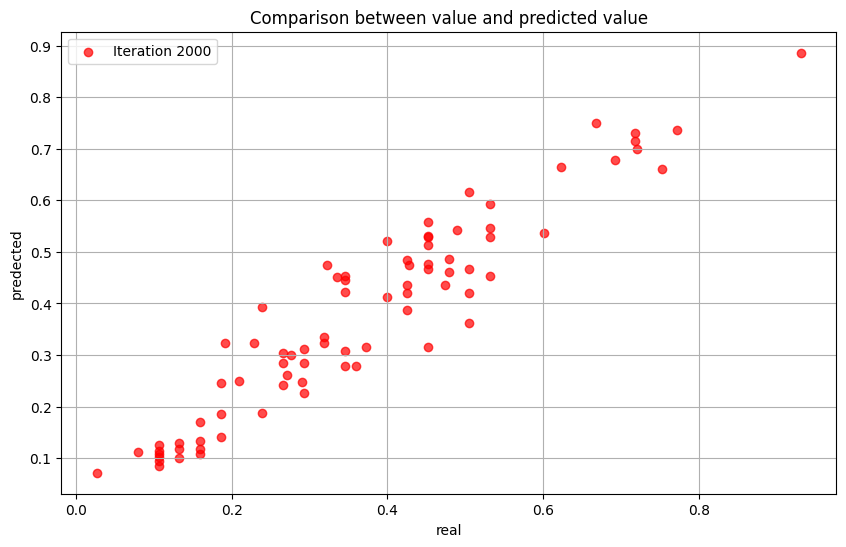

In [27]:
puntos_rojos_ordenados = sorted(puntos_rojos, key=lambda x: x[0])
#puntos_rosa_ordenados = sorted(puntos_rosas, key=lambda x: x[0])

# Extraer coordenadas para graficar
x_rojo = [p[0] for p in puntos_rojos_ordenados]
y_rojo = [p[1] for p in puntos_rojos_ordenados]

#x_rosa = [p[0] for p in puntos_rosa_ordenados]
#y_rosa = [p[1] for p in puntos_rosa_ordenados]

# Crear gráfico
plt.figure(figsize=(10, 6))

# Graficar los puntos rojos (Iteración 2000) y rosa (Iteración 1000)
plt.scatter(x_rojo, y_rojo, color='red', label='Iteration 2000', alpha=0.7)
#plt.scatter(x_rosa, y_rosa, color='blue', label='Iteration 1000', alpha=0.7)

# Etiquetas y leyenda en inglés
plt.xlabel('real')
plt.ylabel('predected')
plt.title('Comparison between value and predicted value')
plt.legend()
plt.grid(True)

# Mostrar gráfico
plt.show()